In [1]:
import numpy as np
from numpy import linalg as LA
import torch; torch.set_default_dtype(torch.float64)
import torch.nn as nn
import torch.optim as optim
import copy
from copy import deepcopy
import matplotlib.pyplot as plt
# import mymodule as myModules
import matplotlib.cm as cm
from scipy import linalg
from timeit import default_timer as timer
import networkx as nx
import os
import pickle
import datetime
#### Import SLOG packakes
from SLOGmodules import SLOGtools as SLOGtools
from SLOGmodules import SLOGobjective as SLOGobj
from SLOGmodules import SLOGarchitectures as SLOGarchi 
from SLOGmodules import SLOGtraining as SLOGtrainer
from SLOGmodules import SLOGmodel as SLOGmodel
from SLOGmodules import SLOGevaluation as SLOGevaluator
from SLOGmodules import SLOGdata as SLOGdata

#### Import GNN packages
from SLOGmodules import graphTools as graphTools
from SLOGmodules import dataTools as dataTools

In [2]:
graphType = 'SBM' # Type of graph
thisFilename_SLOG = 'sourceLocSLOGNET' # This is the general name of all related files
saveDirRoot = 'experiments' # Relative location where to save the file
saveDir = os.path.join(saveDirRoot, thisFilename_SLOG) # Dir where to save all the results from each run

#\\\ Create .txt to store the values of the setting parameters for easier
# reference  when running multiple experiments
today = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
# Append date and time of the run to the directory, to avoid several runs of
# overwritting each other.
saveDir = saveDir + '-' + graphType + '-' + today
# Create directory
if not os.path.exists(saveDir):
    os.makedirs(saveDir)

useGPU = True
if useGPU and torch.cuda.is_available():
    device = 'cuda:0'
    torch.cuda.empty_cache()
else:
    device = 'cpu'
# Notify:
print("Device selected: %s" % device)    

Device selected: cpu


In [3]:
### Data parameters
nNodes = 20
nTrain = 640000
batchsize = 400
nEpochs = 50
nValid = batchsize
nTest = batchsize

### Graph parameters
# graphType = 'SBM'
nClasses = 3
graphOptions = {} # Dictionary of options to pass to the graphTools.createGraph function
graphOptions['nCommunities'] = nClasses # Number of communities
graphOptions['probIntra'] = 0.8 # Probability of drawing edges intra communities
graphOptions['probInter'] = 0.2 # Probability of drawing edges inter communities


### Network parameters
K = 5 # number of layers

### Filter parameters
alpha = 1.0

In [4]:
# Data and graph generation

# graph = SLOGtools.generate_graph(nNode,graph_type)
G = graphTools.Graph(graphType, nNodes, graphOptions)

N_C = 4

sourceNodes, communityLabels,communityList = SLOGtools.computeSourceNodes_slog(G.A, nClasses, N_C, mode = 'random')
d_slog,Lpn_slog, eigenvalues_slog, V_slog   = SLOGtools.get_eig_normalized_adj(G.A)

# g_batch = SLOGtools.g_batch_generate(nNodes,nBatches,alpha)

data = SLOGdata.SLOGdata(G, nTrain, nValid, nTest, sourceNodes, communityList,communityLabels, V_slog,alpha = 1.0, selectMode = 'random',signalMode = 'Gaussion')

data.astype(torch.float64)
data.expandDims()

C =  3 , Community nodes: [ 4 14 15 16 17 18 19]
Degress of community nodes: [10.  6.  8.  8.  5.  8.  7.]
Sorted degress: [4 1 6 2 3 5 0]
Randomized sorted degress: [5 0 4 1 6 2 3]
C =  3 , Community nodes: [0 1 2 3 5 6]
Degress of community nodes: [7. 8. 5. 7. 7. 8.]
Sorted degress: [2 0 3 4 1 5]
Randomized sorted degress: [3 5 4 2 1 0]
C =  3 , Community nodes: [ 7  8  9 10 11 12 13]
Degress of community nodes: [ 7.  8.  7.  6. 10.  6.  8.]
Sorted degress: [3 5 0 2 1 6 4]
Randomized sorted degress: [6 5 0 2 1 4 3]
Source nodes: [array([14, 19, 15, 16], dtype=int64), array([5, 2, 1, 0], dtype=int64), array([ 9,  8, 11, 10], dtype=int64)]
Community Labels: [1 1 1 1 0 1 1 2 2 2 2 2 2 2 0 0 0 0 0 0]
Community List: [array([ 4, 14, 15, 16, 17, 18, 19], dtype=int64), array([0, 1, 2, 3, 5, 6], dtype=int64), array([ 7,  8,  9, 10, 11, 12, 13], dtype=int64)]
Number of input nodes per classes: 4 ; number of classes 3


C:\Users\Chang Ye\python\slog-net-master\graph-neural-networks-master\SLOGmodules\SLOGdata.py:414: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  communityNode_set = np.array(communityList)


Signal shape: torch.Size([640800, 20])


In [5]:
# exit()

In [6]:
C = 1
K = 5
thisLoss = SLOGtools.myLoss
thisObject = SLOGobj.myFunction_slog_1
thisEvaluator = SLOGevaluator.evaluate
SLOG_net = SLOGarchi.GraphSLoG_v1(V_slog,nNodes,C,K, thisObject)

import torch.optim as optim

model_name = 'SLOG-Net'
optimAlg = 'ADAM'
learningRate = 0.01
beta1 = 0.9
beta2 = 0.999

thisOptim = optim.Adam(SLOG_net.parameters(), lr = learningRate)
thisTrainer = SLOGtrainer.slog_Trainer

myModel = SLOGmodel.Model(SLOG_net,thisLoss,thisOptim, thisTrainer,thisEvaluator,device, model_name,  saveDir )

result_train = myModel.train(data,nEpochs, batchsize) # model, data, nEpochs, batchSize



torch.Size([20, 640000]) torch.Size([12800000])
torch.Size([20, 640000])
torch.Size([20, 400]) torch.Size([8000])
torch.Size([20, 400])
torch.Size([20, 400]) torch.Size([8000])
torch.Size([20, 400]) torch.Size([8000])
400
640000
[640000, 640000]
torch.Size([12800000])
torch.Size([20, 400])
Number of Batches: 1600

Epoch 1

    (E:  1, B:   1) 
	 Loss: 0.1965 [T] 0.1831 [V] 	 RE: 0.9907 [T] 	 RE: 0.9955 [V] 	 Best Loss: 0.1831 [V] 	 Loss: 0.2131 [Test]

    (E:  1, B:  21) 
	 Loss: 0.1944 [T] 0.1804 [V] 	 RE: 0.9905 [T] 	 RE: 0.9880 [V] 	 Best Loss: 0.1804 [V] 	 Loss: 0.2044 [Test]
Best model updated at: 0 20
rho_1 tensor([0.8157, 0.0933, 0.9819, 0.0389, 0.3085])
eta_1 tensor([0.0000, 0.3821, 0.0267, 0.3931, 0.0000])
lmbd tensor([0.0832, 0.2456, 0.9811, 0.0000, 0.0886])
alpha_1 tensor([-0.6590, -0.5290, -0.6439, -0.2993,  1.6051])
alpha_2 tensor([ 0.4085,  0.6164, -0.0067,  1.0277, -0.2003])
beta_1 tensor([-0.4369, -1.5020, -0.9699, -0.8803,  0.1689])
beta_2 tensor([ 0.6907, -0.0206,  0


    (E:  1, B: 381) 
	 Loss: 0.0851 [T] 0.0777 [V] 	 RE: 0.6494 [T] 	 RE: 0.6485 [V] 	 Best Loss: 0.0512 [V] 	 Loss: 0.1076 [Test]

    (E:  1, B: 401) 
	 Loss: 0.0716 [T] 0.0603 [V] 	 RE: 0.6032 [T] 	 RE: 0.5715 [V] 	 Best Loss: 0.0512 [V] 	 Loss: 0.1080 [Test]

    (E:  1, B: 421) 
	 Loss: 0.0787 [T] 0.0558 [V] 	 RE: 0.6234 [T] 	 RE: 0.5496 [V] 	 Best Loss: 0.0512 [V] 	 Loss: 0.1082 [Test]

    (E:  1, B: 441) 
	 Loss: 0.0703 [T] 0.0561 [V] 	 RE: 0.5910 [T] 	 RE: 0.5509 [V] 	 Best Loss: 0.0512 [V] 	 Loss: 0.1087 [Test]

    (E:  1, B: 461) 
	 Loss: 0.0569 [T] 0.0332 [V] 	 RE: 0.5518 [T] 	 RE: 0.4240 [V] 	 Best Loss: 0.0332 [V] 	 Loss: 0.1039 [Test]
Best model updated at: 0 460
rho_1 tensor([0.8157, 0.8804, 1.8367, 0.3836, 0.5819])
eta_1 tensor([0.1722, 1.0362, 0.0050, 1.8692, 0.0203])
lmbd tensor([0.2248, 0.3436, 1.2433, 0.3271, 0.0886])
alpha_1 tensor([-1.2299, -0.4231, -0.3777, -0.7339,  1.6051])
alpha_2 tensor([ 0.4085,  0.5148, -0.2430,  1.6240, -0.2003])
beta_1 tensor([-0.4369,


    (E:  1, B: 1421) 
	 Loss: 0.0601 [T] 0.0468 [V] 	 RE: 0.5481 [T] 	 RE: 0.5035 [V] 	 Best Loss: 0.0301 [V] 	 Loss: 0.0929 [Test]

    (E:  1, B: 1441) 
	 Loss: 0.1042 [T] 0.0697 [V] 	 RE: 0.7309 [T] 	 RE: 0.6142 [V] 	 Best Loss: 0.0301 [V] 	 Loss: 0.0933 [Test]

    (E:  1, B: 1461) 
	 Loss: 0.0615 [T] 0.0668 [V] 	 RE: 0.5524 [T] 	 RE: 0.6011 [V] 	 Best Loss: 0.0301 [V] 	 Loss: 0.0926 [Test]

    (E:  1, B: 1481) 
	 Loss: 0.0532 [T] 0.0376 [V] 	 RE: 0.5111 [T] 	 RE: 0.4510 [V] 	 Best Loss: 0.0301 [V] 	 Loss: 0.0997 [Test]

    (E:  1, B: 1501) 
	 Loss: 0.1238 [T] 0.1464 [V] 	 RE: 0.7906 [T] 	 RE: 0.8903 [V] 	 Best Loss: 0.0301 [V] 	 Loss: 0.0960 [Test]

    (E:  1, B: 1521) 
	 Loss: 0.0711 [T] 0.0744 [V] 	 RE: 0.5964 [T] 	 RE: 0.6347 [V] 	 Best Loss: 0.0301 [V] 	 Loss: 0.0904 [Test]

    (E:  1, B: 1541) 
	 Loss: 0.1619 [T] 0.1717 [V] 	 RE: 0.8886 [T] 	 RE: 0.9641 [V] 	 Best Loss: 0.0301 [V] 	 Loss: 0.0940 [Test]

    (E:  1, B: 1561) 
	 Loss: 0.0780 [T] 0.0644 [V] 	 RE: 0.6365 [T]


    (E:  2, B: 961) 
	 Loss: 0.0419 [T] 0.0422 [V] 	 RE: 0.4810 [T] 	 RE: 0.4779 [V] 	 Best Loss: 0.0286 [V] 	 Loss: 0.0803 [Test]

    (E:  2, B: 981) 
	 Loss: 0.0572 [T] 0.0464 [V] 	 RE: 0.5385 [T] 	 RE: 0.5012 [V] 	 Best Loss: 0.0286 [V] 	 Loss: 0.0934 [Test]

    (E:  2, B: 1001) 
	 Loss: 0.0893 [T] 0.0835 [V] 	 RE: 0.6545 [T] 	 RE: 0.6722 [V] 	 Best Loss: 0.0286 [V] 	 Loss: 0.0913 [Test]

    (E:  2, B: 1021) 
	 Loss: 0.0800 [T] 0.0576 [V] 	 RE: 0.6314 [T] 	 RE: 0.5583 [V] 	 Best Loss: 0.0286 [V] 	 Loss: 0.0897 [Test]

    (E:  2, B: 1041) 
	 Loss: 0.0496 [T] 0.0473 [V] 	 RE: 0.4946 [T] 	 RE: 0.5062 [V] 	 Best Loss: 0.0286 [V] 	 Loss: 0.0902 [Test]

    (E:  2, B: 1061) 
	 Loss: 0.0684 [T] 0.0625 [V] 	 RE: 0.5779 [T] 	 RE: 0.5818 [V] 	 Best Loss: 0.0286 [V] 	 Loss: 0.0894 [Test]

    (E:  2, B: 1081) 
	 Loss: 0.1201 [T] 0.1074 [V] 	 RE: 0.7784 [T] 	 RE: 0.7625 [V] 	 Best Loss: 0.0286 [V] 	 Loss: 0.0921 [Test]

    (E:  2, B: 1101) 
	 Loss: 0.0766 [T] 0.0652 [V] 	 RE: 0.6124 [T] 	


    (E:  3, B: 501) 
	 Loss: 0.0515 [T] 0.0597 [V] 	 RE: 0.5017 [T] 	 RE: 0.5684 [V] 	 Best Loss: 0.0280 [V] 	 Loss: 0.0840 [Test]

    (E:  3, B: 521) 
	 Loss: 0.0738 [T] 0.0864 [V] 	 RE: 0.6143 [T] 	 RE: 0.6838 [V] 	 Best Loss: 0.0280 [V] 	 Loss: 0.0951 [Test]

    (E:  3, B: 541) 
	 Loss: 0.0779 [T] 0.0842 [V] 	 RE: 0.6495 [T] 	 RE: 0.6751 [V] 	 Best Loss: 0.0280 [V] 	 Loss: 0.0938 [Test]

    (E:  3, B: 561) 
	 Loss: 0.0771 [T] 0.0690 [V] 	 RE: 0.6122 [T] 	 RE: 0.6113 [V] 	 Best Loss: 0.0280 [V] 	 Loss: 0.0817 [Test]

    (E:  3, B: 581) 
	 Loss: 0.0707 [T] 0.0513 [V] 	 RE: 0.6028 [T] 	 RE: 0.5268 [V] 	 Best Loss: 0.0280 [V] 	 Loss: 0.0843 [Test]

    (E:  3, B: 601) 
	 Loss: 0.0884 [T] 0.0692 [V] 	 RE: 0.6448 [T] 	 RE: 0.6121 [V] 	 Best Loss: 0.0280 [V] 	 Loss: 0.0815 [Test]

    (E:  3, B: 621) 
	 Loss: 0.0737 [T] 0.0808 [V] 	 RE: 0.6019 [T] 	 RE: 0.6612 [V] 	 Best Loss: 0.0280 [V] 	 Loss: 0.0819 [Test]

    (E:  3, B: 641) 
	 Loss: 0.1525 [T] 0.1631 [V] 	 RE: 0.8418 [T] 	 RE: 0


    (E:  3, B: 1541) 
	 Loss: 0.1228 [T] 0.1404 [V] 	 RE: 0.7577 [T] 	 RE: 0.8716 [V] 	 Best Loss: 0.0210 [V] 	 Loss: 0.0864 [Test]

    (E:  3, B: 1561) 
	 Loss: 0.0703 [T] 0.0524 [V] 	 RE: 0.5912 [T] 	 RE: 0.5323 [V] 	 Best Loss: 0.0210 [V] 	 Loss: 0.0763 [Test]

    (E:  3, B: 1581) 
	 Loss: 0.0406 [T] 0.0273 [V] 	 RE: 0.4456 [T] 	 RE: 0.3846 [V] 	 Best Loss: 0.0210 [V] 	 Loss: 0.0777 [Test]
Mean training time =  0.01865772368749992

Epoch 4

    (E:  4, B:   1) 
	 Loss: 0.0698 [T] 0.0619 [V] 	 RE: 0.5903 [T] 	 RE: 0.5790 [V] 	 Best Loss: 0.0210 [V] 	 Loss: 0.0795 [Test]

    (E:  4, B:  21) 
	 Loss: 0.0879 [T] 0.0757 [V] 	 RE: 0.6521 [T] 	 RE: 0.6401 [V] 	 Best Loss: 0.0210 [V] 	 Loss: 0.0818 [Test]

    (E:  4, B:  41) 
	 Loss: 0.0821 [T] 0.0629 [V] 	 RE: 0.6536 [T] 	 RE: 0.5836 [V] 	 Best Loss: 0.0210 [V] 	 Loss: 0.0790 [Test]

    (E:  4, B:  61) 
	 Loss: 0.0688 [T] 0.0558 [V] 	 RE: 0.5717 [T] 	 RE: 0.5497 [V] 	 Best Loss: 0.0210 [V] 	 Loss: 0.0821 [Test]

    (E:  4, B:  81) 



    (E:  4, B: 1181) 
	 Loss: 0.0965 [T] 0.1182 [V] 	 RE: 0.7004 [T] 	 RE: 0.8000 [V] 	 Best Loss: 0.0210 [V] 	 Loss: 0.0661 [Test]

    (E:  4, B: 1201) 
	 Loss: 0.0475 [T] 0.0493 [V] 	 RE: 0.4897 [T] 	 RE: 0.5168 [V] 	 Best Loss: 0.0210 [V] 	 Loss: 0.0748 [Test]

    (E:  4, B: 1221) 
	 Loss: 0.0566 [T] 0.0429 [V] 	 RE: 0.5345 [T] 	 RE: 0.4820 [V] 	 Best Loss: 0.0210 [V] 	 Loss: 0.0770 [Test]

    (E:  4, B: 1241) 
	 Loss: 0.1509 [T] 0.2176 [V] 	 RE: 0.8734 [T] 	 RE: 1.0852 [V] 	 Best Loss: 0.0210 [V] 	 Loss: 0.0657 [Test]

    (E:  4, B: 1261) 
	 Loss: 0.0563 [T] 0.0278 [V] 	 RE: 0.5283 [T] 	 RE: 0.3879 [V] 	 Best Loss: 0.0210 [V] 	 Loss: 0.0726 [Test]

    (E:  4, B: 1281) 
	 Loss: 0.0329 [T] 0.0378 [V] 	 RE: 0.4226 [T] 	 RE: 0.4524 [V] 	 Best Loss: 0.0210 [V] 	 Loss: 0.0707 [Test]

    (E:  4, B: 1301) 
	 Loss: 0.0333 [T] 0.0314 [V] 	 RE: 0.4118 [T] 	 RE: 0.4125 [V] 	 Best Loss: 0.0210 [V] 	 Loss: 0.0739 [Test]

    (E:  4, B: 1321) 
	 Loss: 0.0810 [T] 0.0830 [V] 	 RE: 0.6489 [T]


    (E:  5, B: 621) 
	 Loss: 0.0359 [T] 0.0267 [V] 	 RE: 0.4164 [T] 	 RE: 0.3800 [V] 	 Best Loss: 0.0154 [V] 	 Loss: 0.0508 [Test]

    (E:  5, B: 641) 
	 Loss: 0.1468 [T] 0.1376 [V] 	 RE: 0.8285 [T] 	 RE: 0.8631 [V] 	 Best Loss: 0.0154 [V] 	 Loss: 0.0534 [Test]

    (E:  5, B: 661) 
	 Loss: 0.0218 [T] 0.0230 [V] 	 RE: 0.3310 [T] 	 RE: 0.3531 [V] 	 Best Loss: 0.0154 [V] 	 Loss: 0.0489 [Test]

    (E:  5, B: 681) 
	 Loss: 0.0521 [T] 0.0563 [V] 	 RE: 0.5148 [T] 	 RE: 0.5521 [V] 	 Best Loss: 0.0154 [V] 	 Loss: 0.0460 [Test]

    (E:  5, B: 701) 
	 Loss: 0.0296 [T] 0.0176 [V] 	 RE: 0.3755 [T] 	 RE: 0.3084 [V] 	 Best Loss: 0.0154 [V] 	 Loss: 0.0463 [Test]

    (E:  5, B: 721) 
	 Loss: 0.1310 [T] 0.1032 [V] 	 RE: 0.8299 [T] 	 RE: 0.7474 [V] 	 Best Loss: 0.0154 [V] 	 Loss: 0.0537 [Test]

    (E:  5, B: 741) 
	 Loss: 0.0314 [T] 0.0354 [V] 	 RE: 0.3940 [T] 	 RE: 0.4377 [V] 	 Best Loss: 0.0154 [V] 	 Loss: 0.0415 [Test]

    (E:  5, B: 761) 
	 Loss: 0.0753 [T] 0.0616 [V] 	 RE: 0.6048 [T] 	 RE: 0


    (E:  6, B: 161) 
	 Loss: 0.0166 [T] 0.0252 [V] 	 RE: 0.2881 [T] 	 RE: 0.3696 [V] 	 Best Loss: 0.0100 [V] 	 Loss: 0.0601 [Test]

    (E:  6, B: 181) 
	 Loss: 0.0296 [T] 0.0416 [V] 	 RE: 0.3816 [T] 	 RE: 0.4743 [V] 	 Best Loss: 0.0100 [V] 	 Loss: 0.0597 [Test]

    (E:  6, B: 201) 
	 Loss: 0.0482 [T] 0.0378 [V] 	 RE: 0.4870 [T] 	 RE: 0.4526 [V] 	 Best Loss: 0.0100 [V] 	 Loss: 0.0720 [Test]

    (E:  6, B: 221) 
	 Loss: 0.1243 [T] 0.1273 [V] 	 RE: 0.7770 [T] 	 RE: 0.8302 [V] 	 Best Loss: 0.0100 [V] 	 Loss: 0.0612 [Test]

    (E:  6, B: 241) 
	 Loss: 0.0380 [T] 0.0374 [V] 	 RE: 0.4464 [T] 	 RE: 0.4502 [V] 	 Best Loss: 0.0100 [V] 	 Loss: 0.0546 [Test]

    (E:  6, B: 261) 
	 Loss: 0.0465 [T] 0.0357 [V] 	 RE: 0.4949 [T] 	 RE: 0.4395 [V] 	 Best Loss: 0.0100 [V] 	 Loss: 0.0685 [Test]

    (E:  6, B: 281) 
	 Loss: 0.0533 [T] 0.0425 [V] 	 RE: 0.5115 [T] 	 RE: 0.4793 [V] 	 Best Loss: 0.0100 [V] 	 Loss: 0.0627 [Test]

    (E:  6, B: 301) 
	 Loss: 0.0327 [T] 0.0246 [V] 	 RE: 0.4030 [T] 	 RE: 0


    (E:  6, B: 1381) 
	 Loss: 0.0604 [T] 0.0525 [V] 	 RE: 0.5494 [T] 	 RE: 0.5333 [V] 	 Best Loss: 0.0093 [V] 	 Loss: 0.0452 [Test]

    (E:  6, B: 1401) 
	 Loss: 0.0140 [T] 0.0228 [V] 	 RE: 0.2738 [T] 	 RE: 0.3510 [V] 	 Best Loss: 0.0093 [V] 	 Loss: 0.0412 [Test]

    (E:  6, B: 1421) 
	 Loss: 0.0322 [T] 0.0103 [V] 	 RE: 0.4008 [T] 	 RE: 0.2356 [V] 	 Best Loss: 0.0093 [V] 	 Loss: 0.0524 [Test]

    (E:  6, B: 1441) 
	 Loss: 0.0518 [T] 0.0439 [V] 	 RE: 0.5038 [T] 	 RE: 0.4874 [V] 	 Best Loss: 0.0093 [V] 	 Loss: 0.0405 [Test]

    (E:  6, B: 1461) 
	 Loss: 0.0382 [T] 0.0275 [V] 	 RE: 0.4421 [T] 	 RE: 0.3856 [V] 	 Best Loss: 0.0093 [V] 	 Loss: 0.0499 [Test]

    (E:  6, B: 1481) 
	 Loss: 0.0139 [T] 0.0080 [V] 	 RE: 0.2670 [T] 	 RE: 0.2075 [V] 	 Best Loss: 0.0080 [V] 	 Loss: 0.0441 [Test]
Best model updated at: 5 1480
rho_1 tensor([0.8157, 0.0060, 1.8239, 0.0050, 0.2998])
eta_1 tensor([1.5452, 0.1169, 0.0263, 5.9590, 3.2737])
lmbd tensor([0.4040, 0.3436, 1.5491, 1.3655, 0.0886])
alpha_1 


    (E:  7, B: 821) 
	 Loss: 0.0212 [T] 0.0329 [V] 	 RE: 0.3301 [T] 	 RE: 0.4220 [V] 	 Best Loss: 0.0038 [V] 	 Loss: 0.0241 [Test]

    (E:  7, B: 841) 
	 Loss: 0.0198 [T] 0.0115 [V] 	 RE: 0.3131 [T] 	 RE: 0.2495 [V] 	 Best Loss: 0.0038 [V] 	 Loss: 0.0297 [Test]

    (E:  7, B: 861) 
	 Loss: 0.0235 [T] 0.0266 [V] 	 RE: 0.3432 [T] 	 RE: 0.3792 [V] 	 Best Loss: 0.0038 [V] 	 Loss: 0.0383 [Test]

    (E:  7, B: 881) 
	 Loss: 0.0110 [T] 0.0134 [V] 	 RE: 0.2399 [T] 	 RE: 0.2691 [V] 	 Best Loss: 0.0038 [V] 	 Loss: 0.0359 [Test]

    (E:  7, B: 901) 
	 Loss: 0.0231 [T] 0.0150 [V] 	 RE: 0.3317 [T] 	 RE: 0.2850 [V] 	 Best Loss: 0.0038 [V] 	 Loss: 0.0286 [Test]

    (E:  7, B: 921) 
	 Loss: 0.0207 [T] 0.0170 [V] 	 RE: 0.3193 [T] 	 RE: 0.3038 [V] 	 Best Loss: 0.0038 [V] 	 Loss: 0.0247 [Test]

    (E:  7, B: 941) 
	 Loss: 0.0078 [T] 0.0116 [V] 	 RE: 0.1983 [T] 	 RE: 0.2502 [V] 	 Best Loss: 0.0038 [V] 	 Loss: 0.0294 [Test]

    (E:  7, B: 961) 
	 Loss: 0.0078 [T] 0.0107 [V] 	 RE: 0.2055 [T] 	 RE: 0


    (E:  8, B: 361) 
	 Loss: 0.0792 [T] 0.1278 [V] 	 RE: 0.6204 [T] 	 RE: 0.8318 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0247 [Test]

    (E:  8, B: 381) 
	 Loss: 0.0133 [T] 0.0066 [V] 	 RE: 0.2499 [T] 	 RE: 0.1889 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0299 [Test]

    (E:  8, B: 401) 
	 Loss: 0.0193 [T] 0.0222 [V] 	 RE: 0.3125 [T] 	 RE: 0.3470 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0382 [Test]

    (E:  8, B: 421) 
	 Loss: 0.0037 [T] 0.0053 [V] 	 RE: 0.1374 [T] 	 RE: 0.1693 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0235 [Test]

    (E:  8, B: 441) 
	 Loss: 0.0106 [T] 0.0057 [V] 	 RE: 0.2323 [T] 	 RE: 0.1760 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0247 [Test]

    (E:  8, B: 461) 
	 Loss: 0.0061 [T] 0.0082 [V] 	 RE: 0.1765 [T] 	 RE: 0.2110 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0399 [Test]

    (E:  8, B: 481) 
	 Loss: 0.0069 [T] 0.0072 [V] 	 RE: 0.1895 [T] 	 RE: 0.1972 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0319 [Test]

    (E:  8, B: 501) 
	 Loss: 0.0116 [T] 0.0149 [V] 	 RE: 0.2504 [T] 	 RE: 0

Mean training time =  0.018622555187501284

Epoch 9

    (E:  9, B:   1) 
	 Loss: 0.0252 [T] 0.0156 [V] 	 RE: 0.3515 [T] 	 RE: 0.2902 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0213 [Test]

    (E:  9, B:  21) 
	 Loss: 0.0198 [T] 0.0271 [V] 	 RE: 0.3163 [T] 	 RE: 0.3828 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0292 [Test]

    (E:  9, B:  41) 
	 Loss: 0.0229 [T] 0.0257 [V] 	 RE: 0.3317 [T] 	 RE: 0.3731 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0256 [Test]

    (E:  9, B:  61) 
	 Loss: 0.0222 [T] 0.0167 [V] 	 RE: 0.3344 [T] 	 RE: 0.3006 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0220 [Test]

    (E:  9, B:  81) 
	 Loss: 0.0115 [T] 0.0165 [V] 	 RE: 0.2435 [T] 	 RE: 0.2989 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0266 [Test]

    (E:  9, B: 101) 
	 Loss: 0.0160 [T] 0.0201 [V] 	 RE: 0.2772 [T] 	 RE: 0.3302 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0262 [Test]

    (E:  9, B: 121) 
	 Loss: 0.0121 [T] 0.0093 [V] 	 RE: 0.2492 [T] 	 RE: 0.2249 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0248 [Test]

    (E:  9, B: 141) 
	 


    (E:  9, B: 1241) 
	 Loss: 0.1878 [T] 0.0912 [V] 	 RE: 0.9606 [T] 	 RE: 0.7025 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0327 [Test]

    (E:  9, B: 1261) 
	 Loss: 0.0060 [T] 0.0074 [V] 	 RE: 0.1738 [T] 	 RE: 0.2003 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0313 [Test]

    (E:  9, B: 1281) 
	 Loss: 0.0119 [T] 0.0077 [V] 	 RE: 0.2441 [T] 	 RE: 0.2039 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0257 [Test]

    (E:  9, B: 1301) 
	 Loss: 0.0196 [T] 0.0180 [V] 	 RE: 0.3171 [T] 	 RE: 0.3118 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0251 [Test]

    (E:  9, B: 1321) 
	 Loss: 0.0194 [T] 0.0259 [V] 	 RE: 0.3119 [T] 	 RE: 0.3745 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0250 [Test]

    (E:  9, B: 1341) 
	 Loss: 0.0180 [T] 0.0063 [V] 	 RE: 0.2946 [T] 	 RE: 0.1840 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0261 [Test]

    (E:  9, B: 1361) 
	 Loss: 0.0078 [T] 0.0068 [V] 	 RE: 0.1973 [T] 	 RE: 0.1924 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0216 [Test]

    (E:  9, B: 1381) 
	 Loss: 0.0481 [T] 0.0405 [V] 	 RE: 0.4881 [T]


    (E: 10, B: 881) 
	 Loss: 0.0144 [T] 0.0092 [V] 	 RE: 0.2732 [T] 	 RE: 0.2230 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0231 [Test]

    (E: 10, B: 901) 
	 Loss: 0.0121 [T] 0.0123 [V] 	 RE: 0.2515 [T] 	 RE: 0.2578 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0229 [Test]

    (E: 10, B: 921) 
	 Loss: 0.0157 [T] 0.0172 [V] 	 RE: 0.2750 [T] 	 RE: 0.3052 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0247 [Test]

    (E: 10, B: 941) 
	 Loss: 0.0154 [T] 0.0111 [V] 	 RE: 0.2696 [T] 	 RE: 0.2453 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0230 [Test]

    (E: 10, B: 961) 
	 Loss: 0.0083 [T] 0.0086 [V] 	 RE: 0.2050 [T] 	 RE: 0.2157 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0226 [Test]

    (E: 10, B: 981) 
	 Loss: 0.0141 [T] 0.0092 [V] 	 RE: 0.2657 [T] 	 RE: 0.2226 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0234 [Test]

    (E: 10, B: 1001) 
	 Loss: 0.0224 [T] 0.0335 [V] 	 RE: 0.3359 [T] 	 RE: 0.4261 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0240 [Test]

    (E: 10, B: 1021) 
	 Loss: 0.0367 [T] 0.0761 [V] 	 RE: 0.4194 [T] 	 RE:


    (E: 11, B: 521) 
	 Loss: 0.0188 [T] 0.0362 [V] 	 RE: 0.3063 [T] 	 RE: 0.4429 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0398 [Test]

    (E: 11, B: 541) 
	 Loss: 0.0505 [T] 0.0435 [V] 	 RE: 0.5145 [T] 	 RE: 0.4851 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0338 [Test]

    (E: 11, B: 561) 
	 Loss: 0.0427 [T] 0.0519 [V] 	 RE: 0.4676 [T] 	 RE: 0.5298 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0378 [Test]

    (E: 11, B: 581) 
	 Loss: 0.0308 [T] 0.0164 [V] 	 RE: 0.3919 [T] 	 RE: 0.2976 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0470 [Test]

    (E: 11, B: 601) 
	 Loss: 0.0462 [T] 0.0525 [V] 	 RE: 0.4785 [T] 	 RE: 0.5330 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0285 [Test]

    (E: 11, B: 621) 
	 Loss: 0.0150 [T] 0.0114 [V] 	 RE: 0.2706 [T] 	 RE: 0.2480 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0526 [Test]

    (E: 11, B: 641) 
	 Loss: 0.0795 [T] 0.1381 [V] 	 RE: 0.6486 [T] 	 RE: 0.8647 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0381 [Test]

    (E: 11, B: 661) 
	 Loss: 0.0249 [T] 0.0139 [V] 	 RE: 0.3547 [T] 	 RE: 0


    (E: 12, B: 161) 
	 Loss: 0.0068 [T] 0.0080 [V] 	 RE: 0.1856 [T] 	 RE: 0.2081 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0346 [Test]

    (E: 12, B: 181) 
	 Loss: 0.0272 [T] 0.0136 [V] 	 RE: 0.3675 [T] 	 RE: 0.2712 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0312 [Test]

    (E: 12, B: 201) 
	 Loss: 0.0102 [T] 0.0237 [V] 	 RE: 0.2271 [T] 	 RE: 0.3585 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0189 [Test]

    (E: 12, B: 221) 
	 Loss: 0.0580 [T] 0.0856 [V] 	 RE: 0.5309 [T] 	 RE: 0.6805 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0295 [Test]

    (E: 12, B: 241) 
	 Loss: 0.0109 [T] 0.0128 [V] 	 RE: 0.2313 [T] 	 RE: 0.2630 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0376 [Test]

    (E: 12, B: 261) 
	 Loss: 0.0187 [T] 0.0120 [V] 	 RE: 0.3050 [T] 	 RE: 0.2544 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0243 [Test]

    (E: 12, B: 281) 
	 Loss: 0.0232 [T] 0.0330 [V] 	 RE: 0.3299 [T] 	 RE: 0.4227 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0344 [Test]

    (E: 12, B: 301) 
	 Loss: 0.0181 [T] 0.0055 [V] 	 RE: 0.2955 [T] 	 RE: 0


    (E: 12, B: 1401) 
	 Loss: 0.0136 [T] 0.0114 [V] 	 RE: 0.2661 [T] 	 RE: 0.2485 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0266 [Test]

    (E: 12, B: 1421) 
	 Loss: 0.0105 [T] 0.0100 [V] 	 RE: 0.2346 [T] 	 RE: 0.2325 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0274 [Test]

    (E: 12, B: 1441) 
	 Loss: 0.0299 [T] 0.0347 [V] 	 RE: 0.3872 [T] 	 RE: 0.4336 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0232 [Test]

    (E: 12, B: 1461) 
	 Loss: 0.0208 [T] 0.0085 [V] 	 RE: 0.3203 [T] 	 RE: 0.2143 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0204 [Test]

    (E: 12, B: 1481) 
	 Loss: 0.0074 [T] 0.0111 [V] 	 RE: 0.1959 [T] 	 RE: 0.2455 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0245 [Test]

    (E: 12, B: 1501) 
	 Loss: 0.0827 [T] 0.0777 [V] 	 RE: 0.6218 [T] 	 RE: 0.6486 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0222 [Test]

    (E: 12, B: 1521) 
	 Loss: 0.0187 [T] 0.0196 [V] 	 RE: 0.3074 [T] 	 RE: 0.3261 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0246 [Test]

    (E: 12, B: 1541) 
	 Loss: 0.0881 [T] 0.1063 [V] 	 RE: 0.6763 [T]


    (E: 13, B: 1041) 
	 Loss: 0.0209 [T] 0.0135 [V] 	 RE: 0.3196 [T] 	 RE: 0.2702 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0516 [Test]

    (E: 13, B: 1061) 
	 Loss: 0.0273 [T] 0.0407 [V] 	 RE: 0.3694 [T] 	 RE: 0.4695 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0597 [Test]

    (E: 13, B: 1081) 
	 Loss: 0.0638 [T] 0.1117 [V] 	 RE: 0.5753 [T] 	 RE: 0.7775 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0548 [Test]

    (E: 13, B: 1101) 
	 Loss: 0.0122 [T] 0.0120 [V] 	 RE: 0.2448 [T] 	 RE: 0.2550 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0575 [Test]

    (E: 13, B: 1121) 
	 Loss: 0.0235 [T] 0.0151 [V] 	 RE: 0.3456 [T] 	 RE: 0.2857 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0376 [Test]

    (E: 13, B: 1141) 
	 Loss: 0.0664 [T] 0.0656 [V] 	 RE: 0.5832 [T] 	 RE: 0.5960 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0466 [Test]

    (E: 13, B: 1161) 
	 Loss: 0.1173 [T] 0.0996 [V] 	 RE: 0.7442 [T] 	 RE: 0.7344 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0442 [Test]

    (E: 13, B: 1181) 
	 Loss: 0.0928 [T] 0.0629 [V] 	 RE: 0.6777 [T]


    (E: 14, B: 681) 
	 Loss: 0.0407 [T] 0.0424 [V] 	 RE: 0.4429 [T] 	 RE: 0.4790 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0281 [Test]

    (E: 14, B: 701) 
	 Loss: 0.0108 [T] 0.0156 [V] 	 RE: 0.2315 [T] 	 RE: 0.2906 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0384 [Test]

    (E: 14, B: 721) 
	 Loss: 0.0584 [T] 0.0556 [V] 	 RE: 0.5482 [T] 	 RE: 0.5484 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0243 [Test]

    (E: 14, B: 741) 
	 Loss: 0.0251 [T] 0.0414 [V] 	 RE: 0.3549 [T] 	 RE: 0.4734 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0246 [Test]

    (E: 14, B: 761) 
	 Loss: 0.0748 [T] 0.0646 [V] 	 RE: 0.5999 [T] 	 RE: 0.5913 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0211 [Test]

    (E: 14, B: 781) 
	 Loss: 0.0141 [T] 0.0178 [V] 	 RE: 0.2725 [T] 	 RE: 0.3103 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0240 [Test]

    (E: 14, B: 801) 
	 Loss: 0.0071 [T] 0.0073 [V] 	 RE: 0.1904 [T] 	 RE: 0.1991 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0303 [Test]

    (E: 14, B: 821) 
	 Loss: 0.0238 [T] 0.0263 [V] 	 RE: 0.3528 [T] 	 RE: 0


    (E: 15, B: 321) 
	 Loss: 0.0037 [T] 0.0056 [V] 	 RE: 0.1413 [T] 	 RE: 0.1749 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0270 [Test]

    (E: 15, B: 341) 
	 Loss: 0.0396 [T] 0.0348 [V] 	 RE: 0.4412 [T] 	 RE: 0.4343 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0237 [Test]

    (E: 15, B: 361) 
	 Loss: 0.0731 [T] 0.1024 [V] 	 RE: 0.6124 [T] 	 RE: 0.7444 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0236 [Test]

    (E: 15, B: 381) 
	 Loss: 0.0069 [T] 0.0089 [V] 	 RE: 0.1844 [T] 	 RE: 0.2199 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0227 [Test]

    (E: 15, B: 401) 
	 Loss: 0.0138 [T] 0.0267 [V] 	 RE: 0.2550 [T] 	 RE: 0.3801 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0291 [Test]

    (E: 15, B: 421) 
	 Loss: 0.0089 [T] 0.0062 [V] 	 RE: 0.2063 [T] 	 RE: 0.1838 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0232 [Test]

    (E: 15, B: 441) 
	 Loss: 0.0093 [T] 0.0059 [V] 	 RE: 0.2111 [T] 	 RE: 0.1787 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0239 [Test]

    (E: 15, B: 461) 
	 Loss: 0.0121 [T] 0.0115 [V] 	 RE: 0.2581 [T] 	 RE: 0


    (E: 15, B: 1561) 
	 Loss: 0.0169 [T] 0.0306 [V] 	 RE: 0.2916 [T] 	 RE: 0.4069 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0331 [Test]

    (E: 15, B: 1581) 
	 Loss: 0.0137 [T] 0.0157 [V] 	 RE: 0.2644 [T] 	 RE: 0.2915 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0285 [Test]
Mean training time =  0.01887392312499898

Epoch 16

    (E: 16, B:   1) 
	 Loss: 0.0231 [T] 0.0519 [V] 	 RE: 0.3312 [T] 	 RE: 0.5299 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0276 [Test]

    (E: 16, B:  21) 
	 Loss: 0.0281 [T] 0.0342 [V] 	 RE: 0.3695 [T] 	 RE: 0.4302 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0249 [Test]

    (E: 16, B:  41) 
	 Loss: 0.0285 [T] 0.0252 [V] 	 RE: 0.3855 [T] 	 RE: 0.3697 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0294 [Test]

    (E: 16, B:  61) 
	 Loss: 0.0222 [T] 0.0215 [V] 	 RE: 0.3293 [T] 	 RE: 0.3410 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0229 [Test]

    (E: 16, B:  81) 
	 Loss: 0.0095 [T] 0.0118 [V] 	 RE: 0.2286 [T] 	 RE: 0.2531 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0211 [Test]

    (E: 16, B: 101) 



    (E: 16, B: 1201) 
	 Loss: 0.0293 [T] 0.0413 [V] 	 RE: 0.3768 [T] 	 RE: 0.4727 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0440 [Test]

    (E: 16, B: 1221) 
	 Loss: 0.0428 [T] 0.0195 [V] 	 RE: 0.4519 [T] 	 RE: 0.3251 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0403 [Test]

    (E: 16, B: 1241) 
	 Loss: 0.2158 [T] 0.2060 [V] 	 RE: 1.0181 [T] 	 RE: 1.0558 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0339 [Test]

    (E: 16, B: 1261) 
	 Loss: 0.0144 [T] 0.0074 [V] 	 RE: 0.2657 [T] 	 RE: 0.2007 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0292 [Test]

    (E: 16, B: 1281) 
	 Loss: 0.0128 [T] 0.0078 [V] 	 RE: 0.2476 [T] 	 RE: 0.2049 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0320 [Test]

    (E: 16, B: 1301) 
	 Loss: 0.0136 [T] 0.0193 [V] 	 RE: 0.2608 [T] 	 RE: 0.3231 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0316 [Test]

    (E: 16, B: 1321) 
	 Loss: 0.0358 [T] 0.0331 [V] 	 RE: 0.4239 [T] 	 RE: 0.4232 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0324 [Test]

    (E: 16, B: 1341) 
	 Loss: 0.0072 [T] 0.0058 [V] 	 RE: 0.1926 [T]


    (E: 17, B: 841) 
	 Loss: 0.0113 [T] 0.0123 [V] 	 RE: 0.2389 [T] 	 RE: 0.2581 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0235 [Test]

    (E: 17, B: 861) 
	 Loss: 0.0219 [T] 0.0169 [V] 	 RE: 0.3341 [T] 	 RE: 0.3024 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0228 [Test]

    (E: 17, B: 881) 
	 Loss: 0.0115 [T] 0.0085 [V] 	 RE: 0.2415 [T] 	 RE: 0.2146 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0238 [Test]

    (E: 17, B: 901) 
	 Loss: 0.0121 [T] 0.0134 [V] 	 RE: 0.2499 [T] 	 RE: 0.2692 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0250 [Test]

    (E: 17, B: 921) 
	 Loss: 0.0135 [T] 0.0154 [V] 	 RE: 0.2605 [T] 	 RE: 0.2886 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0228 [Test]

    (E: 17, B: 941) 
	 Loss: 0.0141 [T] 0.0102 [V] 	 RE: 0.2653 [T] 	 RE: 0.2352 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0229 [Test]

    (E: 17, B: 961) 
	 Loss: 0.0072 [T] 0.0097 [V] 	 RE: 0.1864 [T] 	 RE: 0.2287 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0234 [Test]

    (E: 17, B: 981) 
	 Loss: 0.0122 [T] 0.0104 [V] 	 RE: 0.2466 [T] 	 RE: 0


    (E: 18, B: 481) 
	 Loss: 0.0105 [T] 0.0078 [V] 	 RE: 0.2237 [T] 	 RE: 0.2052 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0229 [Test]

    (E: 18, B: 501) 
	 Loss: 0.0082 [T] 0.0099 [V] 	 RE: 0.2095 [T] 	 RE: 0.2314 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0235 [Test]

    (E: 18, B: 521) 
	 Loss: 0.0156 [T] 0.0113 [V] 	 RE: 0.2731 [T] 	 RE: 0.2477 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0232 [Test]

    (E: 18, B: 541) 
	 Loss: 0.0171 [T] 0.0221 [V] 	 RE: 0.2987 [T] 	 RE: 0.3458 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0231 [Test]

    (E: 18, B: 561) 
	 Loss: 0.0207 [T] 0.0153 [V] 	 RE: 0.3168 [T] 	 RE: 0.2875 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0232 [Test]

    (E: 18, B: 581) 
	 Loss: 0.0149 [T] 0.0117 [V] 	 RE: 0.2773 [T] 	 RE: 0.2518 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0239 [Test]

    (E: 18, B: 601) 
	 Loss: 0.0301 [T] 0.0360 [V] 	 RE: 0.3992 [T] 	 RE: 0.4412 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0267 [Test]

    (E: 18, B: 621) 
	 Loss: 0.0140 [T] 0.0099 [V] 	 RE: 0.2681 [T] 	 RE: 0


    (E: 19, B: 121) 
	 Loss: 0.0076 [T] 0.0076 [V] 	 RE: 0.1980 [T] 	 RE: 0.2030 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0233 [Test]

    (E: 19, B: 141) 
	 Loss: 0.0093 [T] 0.0154 [V] 	 RE: 0.2147 [T] 	 RE: 0.2892 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0252 [Test]

    (E: 19, B: 161) 
	 Loss: 0.0095 [T] 0.0116 [V] 	 RE: 0.2238 [T] 	 RE: 0.2505 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0250 [Test]

    (E: 19, B: 181) 
	 Loss: 0.0197 [T] 0.0154 [V] 	 RE: 0.3260 [T] 	 RE: 0.2888 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0376 [Test]

    (E: 19, B: 201) 
	 Loss: 0.0129 [T] 0.0128 [V] 	 RE: 0.2617 [T] 	 RE: 0.2633 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0252 [Test]

    (E: 19, B: 221) 
	 Loss: 0.0501 [T] 0.0425 [V] 	 RE: 0.5097 [T] 	 RE: 0.4794 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0237 [Test]

    (E: 19, B: 241) 
	 Loss: 0.0103 [T] 0.0093 [V] 	 RE: 0.2318 [T] 	 RE: 0.2238 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0238 [Test]

    (E: 19, B: 261) 
	 Loss: 0.0134 [T] 0.0135 [V] 	 RE: 0.2518 [T] 	 RE: 0


    (E: 19, B: 1361) 
	 Loss: 0.0048 [T] 0.0056 [V] 	 RE: 0.1508 [T] 	 RE: 0.1740 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0257 [Test]

    (E: 19, B: 1381) 
	 Loss: 0.0440 [T] 0.0382 [V] 	 RE: 0.4582 [T] 	 RE: 0.4548 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0261 [Test]

    (E: 19, B: 1401) 
	 Loss: 0.0096 [T] 0.0137 [V] 	 RE: 0.2148 [T] 	 RE: 0.2725 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0365 [Test]

    (E: 19, B: 1421) 
	 Loss: 0.0112 [T] 0.0087 [V] 	 RE: 0.2369 [T] 	 RE: 0.2166 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0239 [Test]

    (E: 19, B: 1441) 
	 Loss: 0.0295 [T] 0.0346 [V] 	 RE: 0.4119 [T] 	 RE: 0.4325 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0225 [Test]

    (E: 19, B: 1461) 
	 Loss: 0.0107 [T] 0.0057 [V] 	 RE: 0.2296 [T] 	 RE: 0.1763 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0250 [Test]

    (E: 19, B: 1481) 
	 Loss: 0.0078 [T] 0.0141 [V] 	 RE: 0.1968 [T] 	 RE: 0.2760 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0298 [Test]

    (E: 19, B: 1501) 
	 Loss: 0.0605 [T] 0.0726 [V] 	 RE: 0.5553 [T]


    (E: 20, B: 1001) 
	 Loss: 0.0316 [T] 0.0313 [V] 	 RE: 0.3990 [T] 	 RE: 0.4118 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0257 [Test]

    (E: 20, B: 1021) 
	 Loss: 0.0401 [T] 0.0309 [V] 	 RE: 0.4414 [T] 	 RE: 0.4090 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0445 [Test]

    (E: 20, B: 1041) 
	 Loss: 0.0214 [T] 0.0108 [V] 	 RE: 0.3353 [T] 	 RE: 0.2420 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0451 [Test]

    (E: 20, B: 1061) 
	 Loss: 0.0299 [T] 0.0369 [V] 	 RE: 0.3805 [T] 	 RE: 0.4470 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0569 [Test]

    (E: 20, B: 1081) 
	 Loss: 0.0750 [T] 0.0691 [V] 	 RE: 0.6001 [T] 	 RE: 0.6114 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0560 [Test]

    (E: 20, B: 1101) 
	 Loss: 0.0062 [T] 0.0096 [V] 	 RE: 0.1757 [T] 	 RE: 0.2275 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0445 [Test]

    (E: 20, B: 1121) 
	 Loss: 0.0211 [T] 0.0231 [V] 	 RE: 0.3208 [T] 	 RE: 0.3534 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0428 [Test]

    (E: 20, B: 1141) 
	 Loss: 0.0935 [T] 0.0680 [V] 	 RE: 0.6754 [T]


    (E: 21, B: 641) 
	 Loss: 0.0622 [T] 0.0823 [V] 	 RE: 0.5589 [T] 	 RE: 0.6673 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0249 [Test]

    (E: 21, B: 661) 
	 Loss: 0.0109 [T] 0.0159 [V] 	 RE: 0.2313 [T] 	 RE: 0.2935 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0283 [Test]

    (E: 21, B: 681) 
	 Loss: 0.0326 [T] 0.0452 [V] 	 RE: 0.3999 [T] 	 RE: 0.4949 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0284 [Test]

    (E: 21, B: 701) 
	 Loss: 0.0160 [T] 0.0275 [V] 	 RE: 0.2801 [T] 	 RE: 0.3857 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0304 [Test]

    (E: 21, B: 721) 
	 Loss: 0.0643 [T] 0.0626 [V] 	 RE: 0.5577 [T] 	 RE: 0.5820 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0208 [Test]

    (E: 21, B: 741) 
	 Loss: 0.0233 [T] 0.0278 [V] 	 RE: 0.3408 [T] 	 RE: 0.3879 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0231 [Test]

    (E: 21, B: 761) 
	 Loss: 0.0582 [T] 0.0618 [V] 	 RE: 0.5308 [T] 	 RE: 0.5783 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0245 [Test]

    (E: 21, B: 781) 
	 Loss: 0.0161 [T] 0.0165 [V] 	 RE: 0.2858 [T] 	 RE: 0


    (E: 22, B: 281) 
	 Loss: 0.0142 [T] 0.0197 [V] 	 RE: 0.2722 [T] 	 RE: 0.3266 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0243 [Test]

    (E: 22, B: 301) 
	 Loss: 0.0086 [T] 0.0084 [V] 	 RE: 0.2087 [T] 	 RE: 0.2126 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0226 [Test]

    (E: 22, B: 321) 
	 Loss: 0.0085 [T] 0.0045 [V] 	 RE: 0.2016 [T] 	 RE: 0.1567 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0226 [Test]

    (E: 22, B: 341) 
	 Loss: 0.0492 [T] 0.0353 [V] 	 RE: 0.4972 [T] 	 RE: 0.4372 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0313 [Test]

    (E: 22, B: 361) 
	 Loss: 0.0867 [T] 0.1052 [V] 	 RE: 0.6545 [T] 	 RE: 0.7545 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0235 [Test]

    (E: 22, B: 381) 
	 Loss: 0.0073 [T] 0.0038 [V] 	 RE: 0.1915 [T] 	 RE: 0.1425 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0215 [Test]

    (E: 22, B: 401) 
	 Loss: 0.0157 [T] 0.0143 [V] 	 RE: 0.2840 [T] 	 RE: 0.2785 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0234 [Test]

    (E: 22, B: 421) 
	 Loss: 0.0060 [T] 0.0081 [V] 	 RE: 0.1732 [T] 	 RE: 0


    (E: 22, B: 1521) 
	 Loss: 0.0169 [T] 0.0165 [V] 	 RE: 0.2940 [T] 	 RE: 0.2992 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0243 [Test]

    (E: 22, B: 1541) 
	 Loss: 0.0678 [T] 0.0591 [V] 	 RE: 0.5836 [T] 	 RE: 0.5657 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0235 [Test]

    (E: 22, B: 1561) 
	 Loss: 0.0089 [T] 0.0177 [V] 	 RE: 0.2132 [T] 	 RE: 0.3098 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0279 [Test]

    (E: 22, B: 1581) 
	 Loss: 0.0143 [T] 0.0150 [V] 	 RE: 0.2721 [T] 	 RE: 0.2853 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0253 [Test]
Mean training time =  0.01882550743750265

Epoch 23

    (E: 23, B:   1) 
	 Loss: 0.0162 [T] 0.0193 [V] 	 RE: 0.2914 [T] 	 RE: 0.3234 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0245 [Test]

    (E: 23, B:  21) 
	 Loss: 0.0286 [T] 0.0206 [V] 	 RE: 0.3772 [T] 	 RE: 0.3342 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0235 [Test]

    (E: 23, B:  41) 
	 Loss: 0.0247 [T] 0.0191 [V] 	 RE: 0.3469 [T] 	 RE: 0.3214 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0244 [Test]

    (E: 23, B:  61)


    (E: 23, B: 1161) 
	 Loss: 0.0827 [T] 0.0902 [V] 	 RE: 0.6450 [T] 	 RE: 0.6986 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0239 [Test]

    (E: 23, B: 1181) 
	 Loss: 0.0598 [T] 0.0546 [V] 	 RE: 0.5462 [T] 	 RE: 0.5436 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0295 [Test]

    (E: 23, B: 1201) 
	 Loss: 0.0242 [T] 0.0241 [V] 	 RE: 0.3464 [T] 	 RE: 0.3614 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0288 [Test]

    (E: 23, B: 1221) 
	 Loss: 0.0109 [T] 0.0085 [V] 	 RE: 0.2321 [T] 	 RE: 0.2141 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0274 [Test]

    (E: 23, B: 1241) 
	 Loss: 0.1042 [T] 0.1016 [V] 	 RE: 0.7265 [T] 	 RE: 0.7414 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0257 [Test]

    (E: 23, B: 1261) 
	 Loss: 0.0059 [T] 0.0066 [V] 	 RE: 0.1743 [T] 	 RE: 0.1891 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0259 [Test]

    (E: 23, B: 1281) 
	 Loss: 0.0066 [T] 0.0075 [V] 	 RE: 0.1813 [T] 	 RE: 0.2018 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0255 [Test]

    (E: 23, B: 1301) 
	 Loss: 0.0230 [T] 0.0249 [V] 	 RE: 0.3425 [T]


    (E: 24, B: 801) 
	 Loss: 0.0117 [T] 0.0090 [V] 	 RE: 0.2382 [T] 	 RE: 0.2201 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0257 [Test]

    (E: 24, B: 821) 
	 Loss: 0.0259 [T] 0.0334 [V] 	 RE: 0.3584 [T] 	 RE: 0.4250 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0257 [Test]

    (E: 24, B: 841) 
	 Loss: 0.0139 [T] 0.0120 [V] 	 RE: 0.2586 [T] 	 RE: 0.2549 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0252 [Test]

    (E: 24, B: 861) 
	 Loss: 0.0237 [T] 0.0185 [V] 	 RE: 0.3508 [T] 	 RE: 0.3164 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0232 [Test]

    (E: 24, B: 881) 
	 Loss: 0.0159 [T] 0.0084 [V] 	 RE: 0.2769 [T] 	 RE: 0.2131 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0234 [Test]

    (E: 24, B: 901) 
	 Loss: 0.0089 [T] 0.0120 [V] 	 RE: 0.2061 [T] 	 RE: 0.2548 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0232 [Test]

    (E: 24, B: 921) 
	 Loss: 0.0109 [T] 0.0158 [V] 	 RE: 0.2302 [T] 	 RE: 0.2922 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0232 [Test]

    (E: 24, B: 941) 
	 Loss: 0.0090 [T] 0.0115 [V] 	 RE: 0.2117 [T] 	 RE: 0


    (E: 25, B: 441) 
	 Loss: 0.0047 [T] 0.0069 [V] 	 RE: 0.1540 [T] 	 RE: 0.1931 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0235 [Test]

    (E: 25, B: 461) 
	 Loss: 0.0071 [T] 0.0209 [V] 	 RE: 0.1837 [T] 	 RE: 0.3364 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0282 [Test]

    (E: 25, B: 481) 
	 Loss: 0.0063 [T] 0.0091 [V] 	 RE: 0.1794 [T] 	 RE: 0.2219 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0241 [Test]

    (E: 25, B: 501) 
	 Loss: 0.0098 [T] 0.0096 [V] 	 RE: 0.2186 [T] 	 RE: 0.2277 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0237 [Test]

    (E: 25, B: 521) 
	 Loss: 0.0129 [T] 0.0120 [V] 	 RE: 0.2511 [T] 	 RE: 0.2553 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0232 [Test]

    (E: 25, B: 541) 
	 Loss: 0.0265 [T] 0.0236 [V] 	 RE: 0.3674 [T] 	 RE: 0.3572 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0229 [Test]

    (E: 25, B: 561) 
	 Loss: 0.0155 [T] 0.0222 [V] 	 RE: 0.2841 [T] 	 RE: 0.3465 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0235 [Test]

    (E: 25, B: 581) 
	 Loss: 0.0147 [T] 0.0120 [V] 	 RE: 0.2820 [T] 	 RE: 0


    (E: 26, B:  81) 
	 Loss: 0.0151 [T] 0.0174 [V] 	 RE: 0.2756 [T] 	 RE: 0.3072 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0239 [Test]

    (E: 26, B: 101) 
	 Loss: 0.0306 [T] 0.0273 [V] 	 RE: 0.3964 [T] 	 RE: 0.3841 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0239 [Test]

    (E: 26, B: 121) 
	 Loss: 0.0154 [T] 0.0079 [V] 	 RE: 0.2701 [T] 	 RE: 0.2068 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0237 [Test]

    (E: 26, B: 141) 
	 Loss: 0.0107 [T] 0.0126 [V] 	 RE: 0.2276 [T] 	 RE: 0.2606 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0237 [Test]

    (E: 26, B: 161) 
	 Loss: 0.0085 [T] 0.0117 [V] 	 RE: 0.2047 [T] 	 RE: 0.2521 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0258 [Test]

    (E: 26, B: 181) 
	 Loss: 0.0170 [T] 0.0106 [V] 	 RE: 0.2869 [T] 	 RE: 0.2396 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0232 [Test]

    (E: 26, B: 201) 
	 Loss: 0.0152 [T] 0.0114 [V] 	 RE: 0.2802 [T] 	 RE: 0.2486 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0235 [Test]

    (E: 26, B: 221) 
	 Loss: 0.0486 [T] 0.0436 [V] 	 RE: 0.4912 [T] 	 RE: 0


    (E: 26, B: 1321) 
	 Loss: 0.0184 [T] 0.0301 [V] 	 RE: 0.3016 [T] 	 RE: 0.4037 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0252 [Test]

    (E: 26, B: 1341) 
	 Loss: 0.0082 [T] 0.0060 [V] 	 RE: 0.2071 [T] 	 RE: 0.1799 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0231 [Test]

    (E: 26, B: 1361) 
	 Loss: 0.0111 [T] 0.0101 [V] 	 RE: 0.2364 [T] 	 RE: 0.2339 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0233 [Test]

    (E: 26, B: 1381) 
	 Loss: 0.0350 [T] 0.0413 [V] 	 RE: 0.4244 [T] 	 RE: 0.4728 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0224 [Test]

    (E: 26, B: 1401) 
	 Loss: 0.0129 [T] 0.0140 [V] 	 RE: 0.2564 [T] 	 RE: 0.2755 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0230 [Test]

    (E: 26, B: 1421) 
	 Loss: 0.0120 [T] 0.0094 [V] 	 RE: 0.2338 [T] 	 RE: 0.2258 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0250 [Test]

    (E: 26, B: 1441) 
	 Loss: 0.0384 [T] 0.0281 [V] 	 RE: 0.4300 [T] 	 RE: 0.3903 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0239 [Test]

    (E: 26, B: 1461) 
	 Loss: 0.0110 [T] 0.0086 [V] 	 RE: 0.2379 [T]


    (E: 27, B: 961) 
	 Loss: 0.0086 [T] 0.0094 [V] 	 RE: 0.2134 [T] 	 RE: 0.2258 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0241 [Test]

    (E: 27, B: 981) 
	 Loss: 0.0127 [T] 0.0107 [V] 	 RE: 0.2549 [T] 	 RE: 0.2410 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0243 [Test]

    (E: 27, B: 1001) 
	 Loss: 0.0445 [T] 0.0348 [V] 	 RE: 0.4653 [T] 	 RE: 0.4340 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0230 [Test]

    (E: 27, B: 1021) 
	 Loss: 0.0403 [T] 0.0225 [V] 	 RE: 0.4502 [T] 	 RE: 0.3493 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0309 [Test]

    (E: 27, B: 1041) 
	 Loss: 0.0118 [T] 0.0077 [V] 	 RE: 0.2472 [T] 	 RE: 0.2039 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0273 [Test]

    (E: 27, B: 1061) 
	 Loss: 0.0190 [T] 0.0174 [V] 	 RE: 0.3093 [T] 	 RE: 0.3066 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0255 [Test]

    (E: 27, B: 1081) 
	 Loss: 0.0628 [T] 0.0731 [V] 	 RE: 0.5530 [T] 	 RE: 0.6291 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0312 [Test]

    (E: 27, B: 1101) 
	 Loss: 0.0095 [T] 0.0148 [V] 	 RE: 0.2212 [T] 	


    (E: 28, B: 601) 
	 Loss: 0.0277 [T] 0.0267 [V] 	 RE: 0.3766 [T] 	 RE: 0.3803 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0241 [Test]

    (E: 28, B: 621) 
	 Loss: 0.0113 [T] 0.0102 [V] 	 RE: 0.2372 [T] 	 RE: 0.2351 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0264 [Test]

    (E: 28, B: 641) 
	 Loss: 0.0728 [T] 0.0798 [V] 	 RE: 0.6203 [T] 	 RE: 0.6574 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0246 [Test]

    (E: 28, B: 661) 
	 Loss: 0.0103 [T] 0.0132 [V] 	 RE: 0.2288 [T] 	 RE: 0.2674 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0239 [Test]

    (E: 28, B: 681) 
	 Loss: 0.0352 [T] 0.0397 [V] 	 RE: 0.4148 [T] 	 RE: 0.4633 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0235 [Test]

    (E: 28, B: 701) 
	 Loss: 0.0180 [T] 0.0195 [V] 	 RE: 0.3047 [T] 	 RE: 0.3246 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0263 [Test]

    (E: 28, B: 721) 
	 Loss: 0.0728 [T] 0.0543 [V] 	 RE: 0.6021 [T] 	 RE: 0.5421 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0249 [Test]

    (E: 28, B: 741) 
	 Loss: 0.0239 [T] 0.0320 [V] 	 RE: 0.3491 [T] 	 RE: 0


    (E: 29, B: 241) 
	 Loss: 0.0115 [T] 0.0089 [V] 	 RE: 0.2390 [T] 	 RE: 0.2193 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0281 [Test]

    (E: 29, B: 261) 
	 Loss: 0.0117 [T] 0.0127 [V] 	 RE: 0.2442 [T] 	 RE: 0.2626 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0223 [Test]

    (E: 29, B: 281) 
	 Loss: 0.0123 [T] 0.0188 [V] 	 RE: 0.2476 [T] 	 RE: 0.3188 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0216 [Test]

    (E: 29, B: 301) 
	 Loss: 0.0071 [T] 0.0078 [V] 	 RE: 0.1898 [T] 	 RE: 0.2049 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0248 [Test]

    (E: 29, B: 321) 
	 Loss: 0.0036 [T] 0.0043 [V] 	 RE: 0.1347 [T] 	 RE: 0.1525 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0226 [Test]

    (E: 29, B: 341) 
	 Loss: 0.0519 [T] 0.0382 [V] 	 RE: 0.5146 [T] 	 RE: 0.4545 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0226 [Test]

    (E: 29, B: 361) 
	 Loss: 0.0893 [T] 0.0869 [V] 	 RE: 0.6520 [T] 	 RE: 0.6858 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0218 [Test]

    (E: 29, B: 381) 
	 Loss: 0.0039 [T] 0.0043 [V] 	 RE: 0.1450 [T] 	 RE: 0


    (E: 29, B: 1481) 
	 Loss: 0.0050 [T] 0.0045 [V] 	 RE: 0.1586 [T] 	 RE: 0.1567 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0323 [Test]

    (E: 29, B: 1501) 
	 Loss: 0.1018 [T] 0.0911 [V] 	 RE: 0.7206 [T] 	 RE: 0.7024 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0377 [Test]

    (E: 29, B: 1521) 
	 Loss: 0.0289 [T] 0.0243 [V] 	 RE: 0.3798 [T] 	 RE: 0.3629 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0327 [Test]

    (E: 29, B: 1541) 
	 Loss: 0.0813 [T] 0.0672 [V] 	 RE: 0.6337 [T] 	 RE: 0.6030 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0337 [Test]

    (E: 29, B: 1561) 
	 Loss: 0.0291 [T] 0.0213 [V] 	 RE: 0.3792 [T] 	 RE: 0.3392 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0361 [Test]

    (E: 29, B: 1581) 
	 Loss: 0.0083 [T] 0.0139 [V] 	 RE: 0.2038 [T] 	 RE: 0.2740 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0327 [Test]
Mean training time =  0.01887223893750246

Epoch 30

    (E: 30, B:   1) 
	 Loss: 0.0151 [T] 0.0205 [V] 	 RE: 0.2792 [T] 	 RE: 0.3329 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0317 [Test]

    (E: 30, B:  2


    (E: 30, B: 1121) 
	 Loss: 0.0082 [T] 0.0100 [V] 	 RE: 0.2025 [T] 	 RE: 0.2329 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0329 [Test]

    (E: 30, B: 1141) 
	 Loss: 0.0374 [T] 0.0509 [V] 	 RE: 0.4392 [T] 	 RE: 0.5251 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0324 [Test]

    (E: 30, B: 1161) 
	 Loss: 0.0905 [T] 0.0838 [V] 	 RE: 0.6874 [T] 	 RE: 0.6735 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0302 [Test]

    (E: 30, B: 1181) 
	 Loss: 0.0566 [T] 0.0513 [V] 	 RE: 0.5435 [T] 	 RE: 0.5271 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0280 [Test]

    (E: 30, B: 1201) 
	 Loss: 0.0237 [T] 0.0262 [V] 	 RE: 0.3389 [T] 	 RE: 0.3762 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0288 [Test]

    (E: 30, B: 1221) 
	 Loss: 0.0106 [T] 0.0066 [V] 	 RE: 0.2342 [T] 	 RE: 0.1891 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0289 [Test]

    (E: 30, B: 1241) 
	 Loss: 0.0983 [T] 0.0924 [V] 	 RE: 0.7170 [T] 	 RE: 0.7072 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0262 [Test]

    (E: 30, B: 1261) 
	 Loss: 0.0074 [T] 0.0070 [V] 	 RE: 0.1928 [T]


    (E: 31, B: 761) 
	 Loss: 0.0606 [T] 0.0627 [V] 	 RE: 0.5457 [T] 	 RE: 0.5827 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0236 [Test]

    (E: 31, B: 781) 
	 Loss: 0.0242 [T] 0.0170 [V] 	 RE: 0.3391 [T] 	 RE: 0.3030 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0263 [Test]

    (E: 31, B: 801) 
	 Loss: 0.0088 [T] 0.0086 [V] 	 RE: 0.2114 [T] 	 RE: 0.2162 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0239 [Test]

    (E: 31, B: 821) 
	 Loss: 0.0319 [T] 0.0357 [V] 	 RE: 0.3999 [T] 	 RE: 0.4397 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0290 [Test]

    (E: 31, B: 841) 
	 Loss: 0.0075 [T] 0.0121 [V] 	 RE: 0.2003 [T] 	 RE: 0.2554 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0237 [Test]

    (E: 31, B: 861) 
	 Loss: 0.0231 [T] 0.0174 [V] 	 RE: 0.3613 [T] 	 RE: 0.3071 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0240 [Test]

    (E: 31, B: 881) 
	 Loss: 0.0088 [T] 0.0094 [V] 	 RE: 0.2098 [T] 	 RE: 0.2250 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0240 [Test]

    (E: 31, B: 901) 
	 Loss: 0.0098 [T] 0.0146 [V] 	 RE: 0.2250 [T] 	 RE: 0


    (E: 32, B: 401) 
	 Loss: 0.0152 [T] 0.0123 [V] 	 RE: 0.2758 [T] 	 RE: 0.2585 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0249 [Test]

    (E: 32, B: 421) 
	 Loss: 0.0059 [T] 0.0100 [V] 	 RE: 0.1699 [T] 	 RE: 0.2331 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0239 [Test]

    (E: 32, B: 441) 
	 Loss: 0.0110 [T] 0.0066 [V] 	 RE: 0.2301 [T] 	 RE: 0.1886 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0237 [Test]

    (E: 32, B: 461) 
	 Loss: 0.0136 [T] 0.0116 [V] 	 RE: 0.2694 [T] 	 RE: 0.2501 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0208 [Test]

    (E: 32, B: 481) 
	 Loss: 0.0077 [T] 0.0091 [V] 	 RE: 0.1916 [T] 	 RE: 0.2215 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0223 [Test]

    (E: 32, B: 501) 
	 Loss: 0.0094 [T] 0.0095 [V] 	 RE: 0.2182 [T] 	 RE: 0.2271 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0263 [Test]

    (E: 32, B: 521) 
	 Loss: 0.0106 [T] 0.0137 [V] 	 RE: 0.2342 [T] 	 RE: 0.2727 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0255 [Test]

    (E: 32, B: 541) 
	 Loss: 0.0218 [T] 0.0232 [V] 	 RE: 0.3326 [T] 	 RE: 0


    (E: 33, B:  41) 
	 Loss: 0.0188 [T] 0.0215 [V] 	 RE: 0.3131 [T] 	 RE: 0.3409 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0243 [Test]

    (E: 33, B:  61) 
	 Loss: 0.0269 [T] 0.0233 [V] 	 RE: 0.3588 [T] 	 RE: 0.3551 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0249 [Test]

    (E: 33, B:  81) 
	 Loss: 0.0168 [T] 0.0148 [V] 	 RE: 0.2851 [T] 	 RE: 0.2834 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0235 [Test]

    (E: 33, B: 101) 
	 Loss: 0.0303 [T] 0.0286 [V] 	 RE: 0.3834 [T] 	 RE: 0.3933 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0235 [Test]

    (E: 33, B: 121) 
	 Loss: 0.0084 [T] 0.0080 [V] 	 RE: 0.2100 [T] 	 RE: 0.2083 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0234 [Test]

    (E: 33, B: 141) 
	 Loss: 0.0091 [T] 0.0128 [V] 	 RE: 0.2116 [T] 	 RE: 0.2635 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0235 [Test]

    (E: 33, B: 161) 
	 Loss: 0.0128 [T] 0.0107 [V] 	 RE: 0.2435 [T] 	 RE: 0.2406 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0242 [Test]

    (E: 33, B: 181) 
	 Loss: 0.0096 [T] 0.0067 [V] 	 RE: 0.2172 [T] 	 RE: 0


    (E: 33, B: 1281) 
	 Loss: 0.0128 [T] 0.0079 [V] 	 RE: 0.2500 [T] 	 RE: 0.2062 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0224 [Test]

    (E: 33, B: 1301) 
	 Loss: 0.0197 [T] 0.0252 [V] 	 RE: 0.3070 [T] 	 RE: 0.3696 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0236 [Test]

    (E: 33, B: 1321) 
	 Loss: 0.0267 [T] 0.0215 [V] 	 RE: 0.3752 [T] 	 RE: 0.3410 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0237 [Test]

    (E: 33, B: 1341) 
	 Loss: 0.0047 [T] 0.0059 [V] 	 RE: 0.1576 [T] 	 RE: 0.1788 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0217 [Test]

    (E: 33, B: 1361) 
	 Loss: 0.0093 [T] 0.0071 [V] 	 RE: 0.2193 [T] 	 RE: 0.1962 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0261 [Test]

    (E: 33, B: 1381) 
	 Loss: 0.0336 [T] 0.0358 [V] 	 RE: 0.4102 [T] 	 RE: 0.4404 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0230 [Test]

    (E: 33, B: 1401) 
	 Loss: 0.0122 [T] 0.0147 [V] 	 RE: 0.2445 [T] 	 RE: 0.2818 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0247 [Test]

    (E: 33, B: 1421) 
	 Loss: 0.0076 [T] 0.0136 [V] 	 RE: 0.1933 [T]


    (E: 34, B: 921) 
	 Loss: 0.0156 [T] 0.0156 [V] 	 RE: 0.2753 [T] 	 RE: 0.2906 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0228 [Test]

    (E: 34, B: 941) 
	 Loss: 0.0140 [T] 0.0122 [V] 	 RE: 0.2593 [T] 	 RE: 0.2568 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0245 [Test]

    (E: 34, B: 961) 
	 Loss: 0.0068 [T] 0.0102 [V] 	 RE: 0.1841 [T] 	 RE: 0.2347 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0236 [Test]

    (E: 34, B: 981) 
	 Loss: 0.0133 [T] 0.0093 [V] 	 RE: 0.2590 [T] 	 RE: 0.2247 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0235 [Test]

    (E: 34, B: 1001) 
	 Loss: 0.0242 [T] 0.0374 [V] 	 RE: 0.3443 [T] 	 RE: 0.4500 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0237 [Test]

    (E: 34, B: 1021) 
	 Loss: 0.0365 [T] 0.0308 [V] 	 RE: 0.4217 [T] 	 RE: 0.4085 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0468 [Test]

    (E: 34, B: 1041) 
	 Loss: 0.0226 [T] 0.0163 [V] 	 RE: 0.3393 [T] 	 RE: 0.2969 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0411 [Test]

    (E: 34, B: 1061) 
	 Loss: 0.0304 [T] 0.0151 [V] 	 RE: 0.3936 [T] 	 R


    (E: 35, B: 561) 
	 Loss: 0.0243 [T] 0.0148 [V] 	 RE: 0.3561 [T] 	 RE: 0.2832 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0240 [Test]

    (E: 35, B: 581) 
	 Loss: 0.0327 [T] 0.0105 [V] 	 RE: 0.3947 [T] 	 RE: 0.2384 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0228 [Test]

    (E: 35, B: 601) 
	 Loss: 0.0353 [T] 0.0357 [V] 	 RE: 0.4207 [T] 	 RE: 0.4393 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0250 [Test]

    (E: 35, B: 621) 
	 Loss: 0.0128 [T] 0.0142 [V] 	 RE: 0.2518 [T] 	 RE: 0.2776 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0330 [Test]

    (E: 35, B: 641) 
	 Loss: 0.0695 [T] 0.0832 [V] 	 RE: 0.5859 [T] 	 RE: 0.6710 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0250 [Test]

    (E: 35, B: 661) 
	 Loss: 0.0149 [T] 0.0126 [V] 	 RE: 0.2658 [T] 	 RE: 0.2612 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0236 [Test]

    (E: 35, B: 681) 
	 Loss: 0.0344 [T] 0.0417 [V] 	 RE: 0.4074 [T] 	 RE: 0.4748 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0265 [Test]

    (E: 35, B: 701) 
	 Loss: 0.0116 [T] 0.0216 [V] 	 RE: 0.2378 [T] 	 RE: 0


    (E: 36, B: 201) 
	 Loss: 0.0286 [T] 0.0137 [V] 	 RE: 0.3686 [T] 	 RE: 0.2726 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0243 [Test]

    (E: 36, B: 221) 
	 Loss: 0.0459 [T] 0.0607 [V] 	 RE: 0.4876 [T] 	 RE: 0.5732 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0260 [Test]

    (E: 36, B: 241) 
	 Loss: 0.0182 [T] 0.0132 [V] 	 RE: 0.3019 [T] 	 RE: 0.2669 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0308 [Test]

    (E: 36, B: 261) 
	 Loss: 0.0143 [T] 0.0126 [V] 	 RE: 0.2697 [T] 	 RE: 0.2614 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0287 [Test]

    (E: 36, B: 281) 
	 Loss: 0.0174 [T] 0.0196 [V] 	 RE: 0.3017 [T] 	 RE: 0.3261 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0274 [Test]

    (E: 36, B: 301) 
	 Loss: 0.0075 [T] 0.0110 [V] 	 RE: 0.1886 [T] 	 RE: 0.2445 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0233 [Test]

    (E: 36, B: 321) 
	 Loss: 0.0058 [T] 0.0051 [V] 	 RE: 0.1753 [T] 	 RE: 0.1655 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0198 [Test]

    (E: 36, B: 341) 
	 Loss: 0.0457 [T] 0.0379 [V] 	 RE: 0.4701 [T] 	 RE: 0


    (E: 36, B: 1441) 
	 Loss: 0.0317 [T] 0.0359 [V] 	 RE: 0.3984 [T] 	 RE: 0.4405 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0242 [Test]

    (E: 36, B: 1461) 
	 Loss: 0.0128 [T] 0.0067 [V] 	 RE: 0.2440 [T] 	 RE: 0.1906 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0262 [Test]

    (E: 36, B: 1481) 
	 Loss: 0.0091 [T] 0.0117 [V] 	 RE: 0.2164 [T] 	 RE: 0.2516 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0243 [Test]

    (E: 36, B: 1501) 
	 Loss: 0.0697 [T] 0.0712 [V] 	 RE: 0.5904 [T] 	 RE: 0.6208 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0244 [Test]

    (E: 36, B: 1521) 
	 Loss: 0.0175 [T] 0.0169 [V] 	 RE: 0.3087 [T] 	 RE: 0.3023 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0235 [Test]

    (E: 36, B: 1541) 
	 Loss: 0.0774 [T] 0.0775 [V] 	 RE: 0.6226 [T] 	 RE: 0.6477 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0242 [Test]

    (E: 36, B: 1561) 
	 Loss: 0.0244 [T] 0.0160 [V] 	 RE: 0.3466 [T] 	 RE: 0.2944 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0246 [Test]

    (E: 36, B: 1581) 
	 Loss: 0.0131 [T] 0.0128 [V] 	 RE: 0.2561 [T]


    (E: 37, B: 1081) 
	 Loss: 0.0515 [T] 0.0491 [V] 	 RE: 0.5001 [T] 	 RE: 0.5155 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0241 [Test]

    (E: 37, B: 1101) 
	 Loss: 0.0130 [T] 0.0134 [V] 	 RE: 0.2622 [T] 	 RE: 0.2697 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0243 [Test]

    (E: 37, B: 1121) 
	 Loss: 0.0151 [T] 0.0101 [V] 	 RE: 0.2668 [T] 	 RE: 0.2336 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0233 [Test]

    (E: 37, B: 1141) 
	 Loss: 0.0474 [T] 0.0438 [V] 	 RE: 0.4816 [T] 	 RE: 0.4870 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0242 [Test]

    (E: 37, B: 1161) 
	 Loss: 0.0863 [T] 0.0833 [V] 	 RE: 0.6539 [T] 	 RE: 0.6716 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0235 [Test]

    (E: 37, B: 1181) 
	 Loss: 0.0535 [T] 0.0513 [V] 	 RE: 0.5139 [T] 	 RE: 0.5267 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0266 [Test]

    (E: 37, B: 1201) 
	 Loss: 0.0227 [T] 0.0258 [V] 	 RE: 0.3347 [T] 	 RE: 0.3737 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0272 [Test]

    (E: 37, B: 1221) 
	 Loss: 0.0075 [T] 0.0070 [V] 	 RE: 0.1956 [T]


    (E: 38, B: 721) 
	 Loss: 0.0703 [T] 0.0610 [V] 	 RE: 0.5910 [T] 	 RE: 0.5747 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0250 [Test]

    (E: 38, B: 741) 
	 Loss: 0.0233 [T] 0.0284 [V] 	 RE: 0.3455 [T] 	 RE: 0.3922 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0249 [Test]

    (E: 38, B: 761) 
	 Loss: 0.0608 [T] 0.0636 [V] 	 RE: 0.5493 [T] 	 RE: 0.5867 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0237 [Test]

    (E: 38, B: 781) 
	 Loss: 0.0166 [T] 0.0164 [V] 	 RE: 0.2889 [T] 	 RE: 0.2976 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0269 [Test]

    (E: 38, B: 801) 
	 Loss: 0.0103 [T] 0.0090 [V] 	 RE: 0.2273 [T] 	 RE: 0.2209 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0242 [Test]

    (E: 38, B: 821) 
	 Loss: 0.0357 [T] 0.0339 [V] 	 RE: 0.4390 [T] 	 RE: 0.4282 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0263 [Test]

    (E: 38, B: 841) 
	 Loss: 0.0089 [T] 0.0135 [V] 	 RE: 0.2105 [T] 	 RE: 0.2700 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0250 [Test]

    (E: 38, B: 861) 
	 Loss: 0.0185 [T] 0.0175 [V] 	 RE: 0.3057 [T] 	 RE: 0


    (E: 39, B: 361) 
	 Loss: 0.0877 [T] 0.0827 [V] 	 RE: 0.6654 [T] 	 RE: 0.6692 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0232 [Test]

    (E: 39, B: 381) 
	 Loss: 0.0038 [T] 0.0039 [V] 	 RE: 0.1396 [T] 	 RE: 0.1459 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0228 [Test]

    (E: 39, B: 401) 
	 Loss: 0.0192 [T] 0.0136 [V] 	 RE: 0.3175 [T] 	 RE: 0.2709 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0231 [Test]

    (E: 39, B: 421) 
	 Loss: 0.0100 [T] 0.0065 [V] 	 RE: 0.2174 [T] 	 RE: 0.1874 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0235 [Test]

    (E: 39, B: 441) 
	 Loss: 0.0058 [T] 0.0069 [V] 	 RE: 0.1679 [T] 	 RE: 0.1936 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0230 [Test]

    (E: 39, B: 461) 
	 Loss: 0.0105 [T] 0.0136 [V] 	 RE: 0.2310 [T] 	 RE: 0.2714 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0244 [Test]

    (E: 39, B: 481) 
	 Loss: 0.0079 [T] 0.0099 [V] 	 RE: 0.2001 [T] 	 RE: 0.2311 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0241 [Test]

    (E: 39, B: 501) 
	 Loss: 0.0106 [T] 0.0120 [V] 	 RE: 0.2296 [T] 	 RE: 0

Mean training time =  0.015417494875001693

Epoch 40

    (E: 40, B:   1) 
	 Loss: 0.0120 [T] 0.0200 [V] 	 RE: 0.2474 [T] 	 RE: 0.3286 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0232 [Test]

    (E: 40, B:  21) 
	 Loss: 0.0252 [T] 0.0199 [V] 	 RE: 0.3605 [T] 	 RE: 0.3284 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0251 [Test]

    (E: 40, B:  41) 
	 Loss: 0.0279 [T] 0.0179 [V] 	 RE: 0.3764 [T] 	 RE: 0.3109 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0243 [Test]

    (E: 40, B:  61) 
	 Loss: 0.0167 [T] 0.0210 [V] 	 RE: 0.2871 [T] 	 RE: 0.3372 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0241 [Test]

    (E: 40, B:  81) 
	 Loss: 0.0182 [T] 0.0143 [V] 	 RE: 0.2900 [T] 	 RE: 0.2786 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0255 [Test]

    (E: 40, B: 101) 
	 Loss: 0.0207 [T] 0.0352 [V] 	 RE: 0.3147 [T] 	 RE: 0.4366 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0255 [Test]

    (E: 40, B: 121) 
	 Loss: 0.0095 [T] 0.0074 [V] 	 RE: 0.2149 [T] 	 RE: 0.1996 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0227 [Test]

    (E: 40, B: 141) 
	


    (E: 40, B: 1241) 
	 Loss: 0.1222 [T] 0.1027 [V] 	 RE: 0.7514 [T] 	 RE: 0.7455 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0257 [Test]

    (E: 40, B: 1261) 
	 Loss: 0.0051 [T] 0.0086 [V] 	 RE: 0.1607 [T] 	 RE: 0.2152 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0264 [Test]

    (E: 40, B: 1281) 
	 Loss: 0.0070 [T] 0.0136 [V] 	 RE: 0.1879 [T] 	 RE: 0.2717 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0263 [Test]

    (E: 40, B: 1301) 
	 Loss: 0.0207 [T] 0.0227 [V] 	 RE: 0.3257 [T] 	 RE: 0.3502 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0245 [Test]

    (E: 40, B: 1321) 
	 Loss: 0.0313 [T] 0.0243 [V] 	 RE: 0.4071 [T] 	 RE: 0.3625 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0245 [Test]

    (E: 40, B: 1341) 
	 Loss: 0.0083 [T] 0.0056 [V] 	 RE: 0.2012 [T] 	 RE: 0.1734 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0245 [Test]

    (E: 40, B: 1361) 
	 Loss: 0.0079 [T] 0.0085 [V] 	 RE: 0.1977 [T] 	 RE: 0.2146 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0241 [Test]

    (E: 40, B: 1381) 
	 Loss: 0.0387 [T] 0.0336 [V] 	 RE: 0.4395 [T]


    (E: 41, B: 881) 
	 Loss: 0.0113 [T] 0.0086 [V] 	 RE: 0.2376 [T] 	 RE: 0.2162 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0234 [Test]

    (E: 41, B: 901) 
	 Loss: 0.0085 [T] 0.0138 [V] 	 RE: 0.2047 [T] 	 RE: 0.2731 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0232 [Test]

    (E: 41, B: 921) 
	 Loss: 0.0138 [T] 0.0154 [V] 	 RE: 0.2623 [T] 	 RE: 0.2884 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0227 [Test]

    (E: 41, B: 941) 
	 Loss: 0.0100 [T] 0.0119 [V] 	 RE: 0.2262 [T] 	 RE: 0.2538 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0227 [Test]

    (E: 41, B: 961) 
	 Loss: 0.0066 [T] 0.0097 [V] 	 RE: 0.1865 [T] 	 RE: 0.2296 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0231 [Test]

    (E: 41, B: 981) 
	 Loss: 0.0141 [T] 0.0097 [V] 	 RE: 0.2676 [T] 	 RE: 0.2293 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0238 [Test]

    (E: 41, B: 1001) 
	 Loss: 0.0324 [T] 0.0354 [V] 	 RE: 0.3977 [T] 	 RE: 0.4375 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0240 [Test]

    (E: 41, B: 1021) 
	 Loss: 0.0391 [T] 0.0340 [V] 	 RE: 0.4332 [T] 	 RE:


    (E: 42, B: 521) 
	 Loss: 0.0225 [T] 0.0112 [V] 	 RE: 0.3299 [T] 	 RE: 0.2457 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0248 [Test]

    (E: 42, B: 541) 
	 Loss: 0.0245 [T] 0.0240 [V] 	 RE: 0.3469 [T] 	 RE: 0.3607 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0230 [Test]

    (E: 42, B: 561) 
	 Loss: 0.0165 [T] 0.0154 [V] 	 RE: 0.2929 [T] 	 RE: 0.2888 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0237 [Test]

    (E: 42, B: 581) 
	 Loss: 0.0135 [T] 0.0101 [V] 	 RE: 0.2656 [T] 	 RE: 0.2333 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0236 [Test]

    (E: 42, B: 601) 
	 Loss: 0.0275 [T] 0.0321 [V] 	 RE: 0.3757 [T] 	 RE: 0.4168 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0226 [Test]

    (E: 42, B: 621) 
	 Loss: 0.0129 [T] 0.0090 [V] 	 RE: 0.2557 [T] 	 RE: 0.2211 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0286 [Test]

    (E: 42, B: 641) 
	 Loss: 0.0784 [T] 0.0785 [V] 	 RE: 0.6347 [T] 	 RE: 0.6520 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0230 [Test]

    (E: 42, B: 661) 
	 Loss: 0.0137 [T] 0.0141 [V] 	 RE: 0.2641 [T] 	 RE: 0


    (E: 43, B: 161) 
	 Loss: 0.0072 [T] 0.0104 [V] 	 RE: 0.1919 [T] 	 RE: 0.2370 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0232 [Test]

    (E: 43, B: 181) 
	 Loss: 0.0085 [T] 0.0080 [V] 	 RE: 0.2073 [T] 	 RE: 0.2079 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0234 [Test]

    (E: 43, B: 201) 
	 Loss: 0.0162 [T] 0.0115 [V] 	 RE: 0.2853 [T] 	 RE: 0.2492 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0248 [Test]

    (E: 43, B: 221) 
	 Loss: 0.0467 [T] 0.0430 [V] 	 RE: 0.4731 [T] 	 RE: 0.4823 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0219 [Test]

    (E: 43, B: 241) 
	 Loss: 0.0104 [T] 0.0089 [V] 	 RE: 0.2249 [T] 	 RE: 0.2194 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0222 [Test]

    (E: 43, B: 261) 
	 Loss: 0.0118 [T] 0.0128 [V] 	 RE: 0.2441 [T] 	 RE: 0.2636 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0255 [Test]

    (E: 43, B: 281) 
	 Loss: 0.0178 [T] 0.0221 [V] 	 RE: 0.3024 [T] 	 RE: 0.3457 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0242 [Test]

    (E: 43, B: 301) 
	 Loss: 0.0082 [T] 0.0099 [V] 	 RE: 0.2049 [T] 	 RE: 0


    (E: 43, B: 1401) 
	 Loss: 0.0124 [T] 0.0129 [V] 	 RE: 0.2461 [T] 	 RE: 0.2640 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0250 [Test]

    (E: 43, B: 1421) 
	 Loss: 0.0102 [T] 0.0119 [V] 	 RE: 0.2264 [T] 	 RE: 0.2538 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0256 [Test]

    (E: 43, B: 1441) 
	 Loss: 0.0374 [T] 0.0315 [V] 	 RE: 0.4220 [T] 	 RE: 0.4129 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0244 [Test]

    (E: 43, B: 1461) 
	 Loss: 0.0067 [T] 0.0067 [V] 	 RE: 0.1883 [T] 	 RE: 0.1911 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0231 [Test]

    (E: 43, B: 1481) 
	 Loss: 0.0110 [T] 0.0139 [V] 	 RE: 0.2302 [T] 	 RE: 0.2740 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0247 [Test]

    (E: 43, B: 1501) 
	 Loss: 0.0829 [T] 0.0703 [V] 	 RE: 0.6441 [T] 	 RE: 0.6168 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0238 [Test]

    (E: 43, B: 1521) 
	 Loss: 0.0195 [T] 0.0171 [V] 	 RE: 0.3076 [T] 	 RE: 0.3041 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0240 [Test]

    (E: 43, B: 1541) 
	 Loss: 0.0712 [T] 0.0620 [V] 	 RE: 0.5943 [T]


    (E: 44, B: 1041) 
	 Loss: 0.0068 [T] 0.0074 [V] 	 RE: 0.1855 [T] 	 RE: 0.2004 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0263 [Test]

    (E: 44, B: 1061) 
	 Loss: 0.0223 [T] 0.0167 [V] 	 RE: 0.3296 [T] 	 RE: 0.3008 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0255 [Test]

    (E: 44, B: 1081) 
	 Loss: 0.0479 [T] 0.0512 [V] 	 RE: 0.4778 [T] 	 RE: 0.5263 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0254 [Test]

    (E: 44, B: 1101) 
	 Loss: 0.0112 [T] 0.0184 [V] 	 RE: 0.2390 [T] 	 RE: 0.3155 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0278 [Test]

    (E: 44, B: 1121) 
	 Loss: 0.0112 [T] 0.0090 [V] 	 RE: 0.2351 [T] 	 RE: 0.2204 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0258 [Test]

    (E: 44, B: 1141) 
	 Loss: 0.0453 [T] 0.0473 [V] 	 RE: 0.4736 [T] 	 RE: 0.5060 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0252 [Test]

    (E: 44, B: 1161) 
	 Loss: 0.0814 [T] 0.0870 [V] 	 RE: 0.6458 [T] 	 RE: 0.6861 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0239 [Test]

    (E: 44, B: 1181) 
	 Loss: 0.0709 [T] 0.0522 [V] 	 RE: 0.6084 [T]


    (E: 45, B: 681) 
	 Loss: 0.0359 [T] 0.0382 [V] 	 RE: 0.4203 [T] 	 RE: 0.4545 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0253 [Test]

    (E: 45, B: 701) 
	 Loss: 0.0135 [T] 0.0151 [V] 	 RE: 0.2573 [T] 	 RE: 0.2859 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0240 [Test]

    (E: 45, B: 721) 
	 Loss: 0.0636 [T] 0.0616 [V] 	 RE: 0.5811 [T] 	 RE: 0.5773 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0241 [Test]

    (E: 45, B: 741) 
	 Loss: 0.0250 [T] 0.0316 [V] 	 RE: 0.3597 [T] 	 RE: 0.4133 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0247 [Test]

    (E: 45, B: 761) 
	 Loss: 0.0510 [T] 0.0633 [V] 	 RE: 0.4955 [T] 	 RE: 0.5853 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0244 [Test]

    (E: 45, B: 781) 
	 Loss: 0.0189 [T] 0.0151 [V] 	 RE: 0.3115 [T] 	 RE: 0.2861 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0273 [Test]

    (E: 45, B: 801) 
	 Loss: 0.0121 [T] 0.0088 [V] 	 RE: 0.2437 [T] 	 RE: 0.2181 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0264 [Test]

    (E: 45, B: 821) 
	 Loss: 0.0286 [T] 0.0343 [V] 	 RE: 0.3812 [T] 	 RE: 0


    (E: 46, B: 321) 
	 Loss: 0.0026 [T] 0.0038 [V] 	 RE: 0.1186 [T] 	 RE: 0.1432 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0237 [Test]

    (E: 46, B: 341) 
	 Loss: 0.0440 [T] 0.0305 [V] 	 RE: 0.4735 [T] 	 RE: 0.4064 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0233 [Test]

    (E: 46, B: 361) 
	 Loss: 0.0935 [T] 0.0818 [V] 	 RE: 0.6817 [T] 	 RE: 0.6654 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0233 [Test]

    (E: 46, B: 381) 
	 Loss: 0.0059 [T] 0.0065 [V] 	 RE: 0.1703 [T] 	 RE: 0.1880 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0226 [Test]

    (E: 46, B: 401) 
	 Loss: 0.0163 [T] 0.0131 [V] 	 RE: 0.2806 [T] 	 RE: 0.2660 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0226 [Test]

    (E: 46, B: 421) 
	 Loss: 0.0068 [T] 0.0063 [V] 	 RE: 0.1829 [T] 	 RE: 0.1851 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0233 [Test]

    (E: 46, B: 441) 
	 Loss: 0.0050 [T] 0.0070 [V] 	 RE: 0.1538 [T] 	 RE: 0.1942 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0235 [Test]

    (E: 46, B: 461) 
	 Loss: 0.0066 [T] 0.0169 [V] 	 RE: 0.1832 [T] 	 RE: 0


    (E: 46, B: 1561) 
	 Loss: 0.0174 [T] 0.0163 [V] 	 RE: 0.2885 [T] 	 RE: 0.2974 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0257 [Test]

    (E: 46, B: 1581) 
	 Loss: 0.0098 [T] 0.0131 [V] 	 RE: 0.2272 [T] 	 RE: 0.2664 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0231 [Test]
Mean training time =  0.015374207000004247

Epoch 47

    (E: 47, B:   1) 
	 Loss: 0.0202 [T] 0.0180 [V] 	 RE: 0.3095 [T] 	 RE: 0.3123 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0233 [Test]

    (E: 47, B:  21) 
	 Loss: 0.0144 [T] 0.0197 [V] 	 RE: 0.2685 [T] 	 RE: 0.3264 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0235 [Test]

    (E: 47, B:  41) 
	 Loss: 0.0246 [T] 0.0190 [V] 	 RE: 0.3525 [T] 	 RE: 0.3206 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0233 [Test]

    (E: 47, B:  61) 
	 Loss: 0.0213 [T] 0.0216 [V] 	 RE: 0.3144 [T] 	 RE: 0.3420 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0236 [Test]

    (E: 47, B:  81) 
	 Loss: 0.0157 [T] 0.0147 [V] 	 RE: 0.2802 [T] 	 RE: 0.2818 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0229 [Test]

    (E: 47, B: 101) 


    (E: 47, B: 1201) 
	 Loss: 0.0225 [T] 0.0231 [V] 	 RE: 0.3362 [T] 	 RE: 0.3535 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0279 [Test]

    (E: 47, B: 1221) 
	 Loss: 0.0093 [T] 0.0120 [V] 	 RE: 0.2224 [T] 	 RE: 0.2550 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0285 [Test]

    (E: 47, B: 1241) 
	 Loss: 0.1133 [T] 0.0967 [V] 	 RE: 0.7548 [T] 	 RE: 0.7234 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0326 [Test]

    (E: 47, B: 1261) 
	 Loss: 0.0069 [T] 0.0179 [V] 	 RE: 0.1859 [T] 	 RE: 0.3111 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0320 [Test]

    (E: 47, B: 1281) 
	 Loss: 0.0061 [T] 0.0076 [V] 	 RE: 0.1711 [T] 	 RE: 0.2023 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0272 [Test]

    (E: 47, B: 1301) 
	 Loss: 0.0203 [T] 0.0320 [V] 	 RE: 0.2997 [T] 	 RE: 0.4159 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0288 [Test]

    (E: 47, B: 1321) 
	 Loss: 0.0353 [T] 0.0361 [V] 	 RE: 0.4133 [T] 	 RE: 0.4419 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0277 [Test]

    (E: 47, B: 1341) 
	 Loss: 0.0109 [T] 0.0065 [V] 	 RE: 0.2322 [T]


    (E: 48, B: 841) 
	 Loss: 0.0101 [T] 0.0127 [V] 	 RE: 0.2317 [T] 	 RE: 0.2617 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0240 [Test]

    (E: 48, B: 861) 
	 Loss: 0.0241 [T] 0.0169 [V] 	 RE: 0.3453 [T] 	 RE: 0.3027 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0232 [Test]

    (E: 48, B: 881) 
	 Loss: 0.0183 [T] 0.0083 [V] 	 RE: 0.2944 [T] 	 RE: 0.2116 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0241 [Test]

    (E: 48, B: 901) 
	 Loss: 0.0055 [T] 0.0124 [V] 	 RE: 0.1639 [T] 	 RE: 0.2591 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0238 [Test]

    (E: 48, B: 921) 
	 Loss: 0.0143 [T] 0.0164 [V] 	 RE: 0.2682 [T] 	 RE: 0.2980 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0242 [Test]

    (E: 48, B: 941) 
	 Loss: 0.0115 [T] 0.0136 [V] 	 RE: 0.2396 [T] 	 RE: 0.2715 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0261 [Test]

    (E: 48, B: 961) 
	 Loss: 0.0099 [T] 0.0100 [V] 	 RE: 0.2194 [T] 	 RE: 0.2322 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0233 [Test]

    (E: 48, B: 981) 
	 Loss: 0.0160 [T] 0.0093 [V] 	 RE: 0.2886 [T] 	 RE: 0


    (E: 49, B: 481) 
	 Loss: 0.0092 [T] 0.0086 [V] 	 RE: 0.2093 [T] 	 RE: 0.2155 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0229 [Test]

    (E: 49, B: 501) 
	 Loss: 0.0091 [T] 0.0107 [V] 	 RE: 0.2174 [T] 	 RE: 0.2412 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0229 [Test]

    (E: 49, B: 521) 
	 Loss: 0.0132 [T] 0.0119 [V] 	 RE: 0.2493 [T] 	 RE: 0.2540 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0234 [Test]

    (E: 49, B: 541) 
	 Loss: 0.0177 [T] 0.0219 [V] 	 RE: 0.3009 [T] 	 RE: 0.3447 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0242 [Test]

    (E: 49, B: 561) 
	 Loss: 0.0203 [T] 0.0163 [V] 	 RE: 0.3193 [T] 	 RE: 0.2972 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0230 [Test]

    (E: 49, B: 581) 
	 Loss: 0.0154 [T] 0.0110 [V] 	 RE: 0.2775 [T] 	 RE: 0.2443 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0233 [Test]

    (E: 49, B: 601) 
	 Loss: 0.0393 [T] 0.0474 [V] 	 RE: 0.4461 [T] 	 RE: 0.5065 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0278 [Test]

    (E: 49, B: 621) 
	 Loss: 0.0114 [T] 0.0084 [V] 	 RE: 0.2410 [T] 	 RE: 0


    (E: 50, B: 121) 
	 Loss: 0.0124 [T] 0.0079 [V] 	 RE: 0.2449 [T] 	 RE: 0.2067 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0236 [Test]

    (E: 50, B: 141) 
	 Loss: 0.0096 [T] 0.0105 [V] 	 RE: 0.2162 [T] 	 RE: 0.2381 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0231 [Test]

    (E: 50, B: 161) 
	 Loss: 0.0095 [T] 0.0109 [V] 	 RE: 0.2218 [T] 	 RE: 0.2427 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0236 [Test]

    (E: 50, B: 181) 
	 Loss: 0.0084 [T] 0.0067 [V] 	 RE: 0.2067 [T] 	 RE: 0.1898 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0238 [Test]

    (E: 50, B: 201) 
	 Loss: 0.0146 [T] 0.0113 [V] 	 RE: 0.2744 [T] 	 RE: 0.2472 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0241 [Test]

    (E: 50, B: 221) 
	 Loss: 0.0588 [T] 0.0432 [V] 	 RE: 0.5463 [T] 	 RE: 0.4834 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0246 [Test]

    (E: 50, B: 241) 
	 Loss: 0.0117 [T] 0.0094 [V] 	 RE: 0.2457 [T] 	 RE: 0.2256 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0238 [Test]

    (E: 50, B: 261) 
	 Loss: 0.0167 [T] 0.0134 [V] 	 RE: 0.2832 [T] 	 RE: 0


    (E: 50, B: 1361) 
	 Loss: 0.0065 [T] 0.0074 [V] 	 RE: 0.1826 [T] 	 RE: 0.2002 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0253 [Test]

    (E: 50, B: 1381) 
	 Loss: 0.0342 [T] 0.0360 [V] 	 RE: 0.4156 [T] 	 RE: 0.4414 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0234 [Test]

    (E: 50, B: 1401) 
	 Loss: 0.0112 [T] 0.0139 [V] 	 RE: 0.2358 [T] 	 RE: 0.2741 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0235 [Test]

    (E: 50, B: 1421) 
	 Loss: 0.0070 [T] 0.0162 [V] 	 RE: 0.1787 [T] 	 RE: 0.2958 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0282 [Test]

    (E: 50, B: 1441) 
	 Loss: 0.0292 [T] 0.0305 [V] 	 RE: 0.3809 [T] 	 RE: 0.4062 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0243 [Test]

    (E: 50, B: 1461) 
	 Loss: 0.0112 [T] 0.0065 [V] 	 RE: 0.2342 [T] 	 RE: 0.1873 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0238 [Test]

    (E: 50, B: 1481) 
	 Loss: 0.0082 [T] 0.0126 [V] 	 RE: 0.2023 [T] 	 RE: 0.2610 [V] 	 Best Loss: 0.0024 [V] 	 Loss: 0.0243 [Test]

    (E: 50, B: 1501) 
	 Loss: 0.0791 [T] 0.0674 [V] 	 RE: 0.6247 [T]

In [7]:
# gT = data.samples['test']['gT']
# print(gT)
# print(g_test)
for n,p in  myModel.trainer.bestModel.named_parameters():
    if p.requires_grad:
        print(n, p.data)
        

rho_1 tensor([0.8157, 0.0000, 1.8433, 0.0050, 0.2911])
eta_1 tensor([2.0300, 0.0300, 0.3437, 6.2289, 3.8132])
lmbd tensor([0.4040, 0.3436, 1.5491, 1.4869, 0.0886])
alpha_1 tensor([-0.4998, -0.4231,  0.0247, -1.7324,  1.6051])
alpha_2 tensor([ 0.4085,  0.5148, -0.5631,  2.9582, -0.2003])
beta_1 tensor([-0.4369,  0.3491, -3.3183,  0.4943,  0.1689])
beta_2 tensor([ 0.3327,  2.3198,  2.1959,  0.2030, -0.8493])
beta_3 tensor([ 0.7244,  1.2288, -0.1803, -1.4515,  1.8149])
gamma_1 tensor([-0.1841, -3.5399, -0.1684,  2.8500, -0.3869])
gamma_2 tensor([ 0.3638,  1.6827,  0.9950, -0.8163, -1.0812])
gamma_3 tensor([-1.9736,  4.4535, -2.5138, -0.5226, -0.6804])


In [8]:
# result_evaluate = myModel.evaluate(data)
result_evaluate = myModel.evaluate(data, topN = 3)
print(result_evaluate)
# Y_test = (data.samples)['test']['signals']
# X_test = (data.samples)['test']['X0']
# targets_test = (data.samples)['test']['targets']
print(min(myModel.trainer.lossValid))

Sample shape Y: torch.Size([20, 400]) , X: torch.Size([20, 400]) , targets: torch.Size([400])
{'costBest': 0.0275, 'costLast': 0.0075}
{'costBest': 0.0275, 'costLast': 0.0075}
0.0024291215253106485


Re-generate sample shape Y: torch.Size([400, 20])
Sample shape Y: torch.Size([20, 400]) , X: torch.Size([20, 400]) , targets: torch.Size([400])
Sample shape Y: torch.Size([20, 400]) , X: torch.Size([20, 400]) , targets: torch.Size([400])
{'costBest': 0.035, 'costLast': 0.055}
{'costBest': 0.035, 'costLast': 0.055}
torch.Size([20, 400])


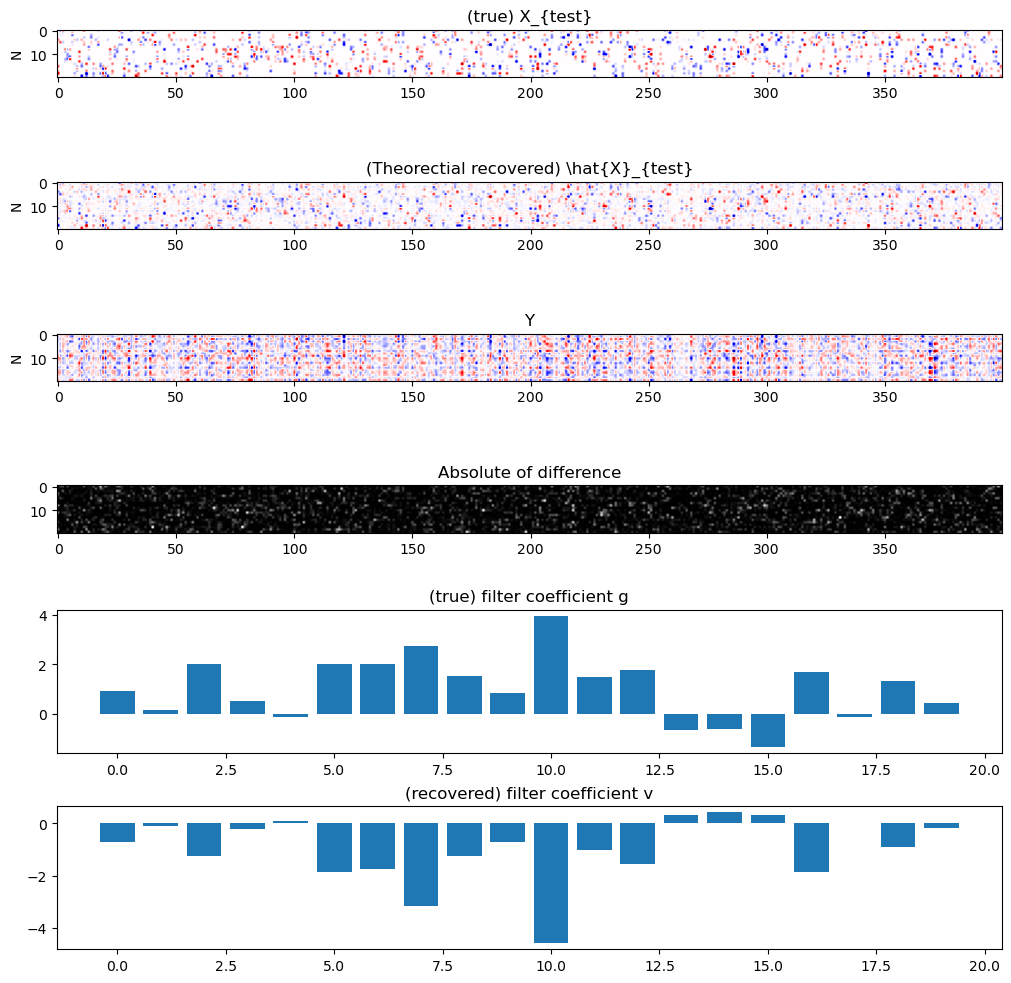

In [13]:
import matplotlib.cm as cm
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# P_test = 400
alpha = 0.1
# theta = 0.2
N = nNodes
# L = 5
# n_batch = batch-1
g_test = np.ones(N)+alpha*np.random.normal(0, 1, N) 
g_test = g_test/np.sum(g_test)
Y_test = data.generate_new_test_Samples(g_test)

Y_test,X_test,targets,g_test = data.get_test_Samples()
# Y_test,X_test,targets = data.get_valid_Samples(g_test)

N = nNodes
P_test = nTest
# bestModel_slog = result_train
bestModel_slog = myModel.trainer.bestModel
# g_test = myModules.g_generate_gso(N,alpha, eigenvalues_slog,L)

# Choose V
# V1 = generate_V(N)
V1 = V_slog

result_evaluate = myModel.evaluate(data, topN = 5)
print(result_evaluate)
# YTest = (data.samples)['test']['signals']
# YTest = torch.reshape(torch.transpose(YTest, 0, 2),(nNodes,nTest_slog))
# yTest = torch.reshape(YTrain, (nNodes*nTest_slog,))
# X_test = (data.samples)['test']['X0']
# X_test = X_test.numpy()
# xTest = torch.reshape(XTest, (nNodes*nTest_slog,))
# yTest = Y[:,nTest_slog:]
# nTest = xTest.shape[1]

# g_test = np.ones(N)+alpha*np.random.normal(0, 1, N)
# h_test = 1./g_test
# H_test = np.dot(V1,np.dot(np.diag(h_test),np.transpose(V1)))
# Y_test = torch.tensor(np.dot(H_test,X_test))

# X_test,Y_test = myModules.Xdata_generate(N,P_test,V1,g_test, theta,alpha)
# Y_test = torch.tensor(Y_test)

# Choose X


# X_test = X_test.reshape(N,P_test)
# print(X_test)
print(X_test.shape)

# H = np.dot(V1,np.dot(np.diag(h_test),np.transpose(V1)))
# Y_test = torch.tensor(np.dot(H,X_test))
# Y_test = yTrainBatch

x_test_Predict, v_test_Predict = bestModel_slog(Y_test)
# x_test_Predict, v_test_Predict = graphFilter(Y_test)

g_pre = v_test_Predict.detach().numpy()
# print(np.transpose(g_test))
# print(g_pre)

G_test = np.dot(V1,np.dot(np.diag(g_pre),np.transpose(V1)))
X_theory = torch.tensor(np.dot(G_test,Y_test)).detach().numpy()

X_test_Predict = x_test_Predict.detach().numpy()
X_test_Predict = X_test_Predict.reshape(N,P_test)

X_test = X_test.numpy()
max_X = np.max(np.abs(X_test))
max_X_theory = np.max(np.abs(X_theory))
max_Y = np.max(np.abs(Y_test.detach().numpy()))
max_XP = np.max(np.abs(X_test_Predict))
fig, axes = plt.subplots(nrows=6, ncols=1, constrained_layout=True,figsize=(10,10))
axes[0].imshow(X_test,  cmap=cm.seismic,vmin = -max_X, vmax = max_X)
axes[0].set_title('(true) X_{test}')
axes[0].set_ylabel('N')
axes[2].imshow(Y_test, cmap=cm.seismic,vmin = -max_Y, vmax = max_Y)
axes[2].set_title('Y')
axes[2].set_ylabel('N')
axes[1].imshow(X_theory, cmap=cm.seismic,vmin = -max_X_theory, vmax = max_X_theory)
axes[1].set_title('(Theorectial recovered) \hat{X}_{test}')
axes[1].set_ylabel('N')
axes[3].imshow(np.abs(X_test_Predict - X_test),  cmap=cm.Greys_r)
axes[3].set_title('Absolute of difference')
axes[4].bar(np.array(range(N)),g_test)
axes[4].set_title('(true) filter coefficient g')
axes[5].bar(np.array(range(N)),g_pre)
axes[5].set_title('(recovered) filter coefficient v')
plt.show()


In [10]:
print()